# Assignment 3

In [76]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from scipy.optimize import curve_fit

In [78]:
from itertools import product

This assignment is broadly based on preliminary work done for the article [*Quantifying massively parallel microbial growth with spatially mediated interactions*](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011585), which consists of a data science approach on analysing high-throughput growth data from [*Scan-o-matic: High-Resolution Microbial Phenomics at a Massive Scale*](https://www.g3journal.org/content/6/9/3003.short).
Please read the paper, it is also in your reading list.

### Loading the data

Let's start by loading the **time series**. The file `curves_raw.npy` is in a `numpy` compressed format, which means that we'll use `np.load` to read it :

In [79]:
data = np.load("curves_raw.npy")
n_plates, n_rows, n_columns, n_points = data.shape

In [80]:
data.shape

(4, 32, 48, 218)

The variable `data` now contains the time series as an `np.array`. It has 4 dimensions, which depict :
1. the plate number
2. the row number
3. the column number
4. the time point

### Transforming into a `pd.DataFrame`

This version of the data is very compact, but **not easily readable**. Let's turn it into a `pd.DataFrame`, so we can add better index and columns names :

In [81]:
Nt = pd.DataFrame(
    data    = data.reshape((n_plates * n_rows * n_columns, n_points)).T,
    columns = pd.MultiIndex.from_product(
        (range(n_plates), range(n_rows), range(n_columns)),
        names = ["plate", "row", "column"]
    ),
    index   = pd.Index(range(n_points), name = "time point")
)

In [82]:
Nt

plate                  0                                            \
row                   0                                              
column                0             1             2             3    
time point                                                           
0           1.227053e+05  1.203836e+05  1.218740e+05  1.122038e+05   
1           1.225209e+05  1.215549e+05  1.211086e+05  1.123983e+05   
2           1.230920e+05  1.227416e+05  1.218727e+05  1.117707e+05   
3           1.251920e+05  1.233259e+05  1.220892e+05  1.133229e+05   
4           1.242257e+05  1.239756e+05  1.224952e+05  1.160752e+05   
...                  ...           ...           ...           ...   
213         2.330646e+06  2.233687e+06  2.377777e+06  2.354889e+06   
214         2.337070e+06  2.253578e+06  2.395804e+06  2.364890e+06   
215         2.357753e+06  2.278665e+06  2.408997e+06  2.386145e+06   
216         2.386464e+06  2.284362e+06  2.413036e+06  2.401709e+06   
217         2.429447e+06  2.322210e+06  2.466192e+06  2.440546e+06   

plate                                                               \
row                                                                  
column                4             5             6             7    
time point                                                           
0           1.195012e+05  1.257932e+05  1.168576e+05  1.169918e+05   
1           1.200848e+05  1.256358e+05  1.167025e+05  1.165890e+05   
2           1.203958e+05  1.265443e+05  1.169361e+05  1.180993e+05   
3           1.211422e+05  1.270652e+05  1.188205e+05  1.188986e+05   
4           1.226693e+05  1.266663e+05  1.194339e+05  1.191711e+05   
...                  ...           ...           ...           ...   
213         2.447459e+06  2.465126e+06  2.408823e+06  2.367808e+06   
214         2.466886e+06  2.473577e+06  2.413429e+06  2.385059e+06   
215         2.486970e+06  2.482885e+06  2.437349e+06  2.397261e+06   
216         2.482630e+06  2.488741e+06  2.442331e+06  2.397717e+06   
217         2.517304e+06  2.539021e+06  2.468901e+06  2.446979e+06   

plate                                   ...             3                \
row                                     ...            31                 
column                8             9   ...            38            39   
time point                              ...                               
0           1.266355e+05  1.130488e+05  ...  9.275295e+04  8.766833e+04   
1           1.230143e+05  1.113131e+05  ...  9.431246e+04  8.763063e+04   
2           1.261672e+05  1.135962e+05  ...  9.490312e+04  9.007879e+04   
3           1.268957e+05  1.139188e+05  ...  9.749966e+04  9.023203e+04   
4           1.278217e+05  1.153194e+05  ...  1.003918e+05  9.303461e+04   
...                  ...           ...  ...           ...           ...   
213         2.401549e+06  2.322400e+06  ...  4.791791e+06  4.797189e+06   
214         2.404660e+06  2.333240e+06  ...  4.801539e+06  4.815928e+06   
215         2.418590e+06  2.353260e+06  ...  4.815232e+06  4.824689e+06   
216         2.425139e+06  2.363916e+06  ...  4.820457e+06  4.816777e+06   
217         2.472432e+06  2.381219e+06  ...  4.942228e+06  4.952565e+06   

plate                                                               \
row                                                                  
column                40            41            42            43   
time point                                                           
0           6.815652e+04  7.459805e+04  7.894468e+04  8.143646e+04   
1           6.876755e+04  7.438883e+04  7.884551e+04  8.335663e+04   
2           7.013537e+04  7.512010e+04  8.085450e+04  8.336089e+04   
3           7.147148e+04  7.613303e+04  8.334405e+04  8.476835e+04   
4           7.241803e+04  7.774415e+04  8.406179e+04  8.604513e+04   
...                  ...           ...           ...           ...   
213         4.543173e+06  4.752974e+06  4.940661e+06  5.100188e+06   
21

This way, a specific time serie can be accessed in a similar fashion to the above `np.array` :

In [83]:
Nt[0, 0, 0]

time point
0      1.227053e+05
1      1.225209e+05
2      1.230920e+05
3      1.251920e+05
4      1.242257e+05
           ...     
213    2.330646e+06
214    2.337070e+06
215    2.357753e+06
216    2.386464e+06
217    2.429447e+06
Name: (0, 0, 0), Length: 218, dtype: float64

### Additional calculation : distance to the border of the plate

This assignment will require the use of specific additional data, which is the **inverse distance** of each grid point to the **closest border of the plate**.
This calculation is here quickly done for you :

In [84]:
dists = np.empty((n_rows, n_columns))

for r in range(n_rows):
    for c in range(n_columns):
    #   distance to top/left/bottom/right wall
        m = min(r, c, n_rows-1 - r, n_columns-1 - c)
        
        dists[r, c] = 1 / (1 + m)

Text(50.722222222222214, 0.5, 'row')

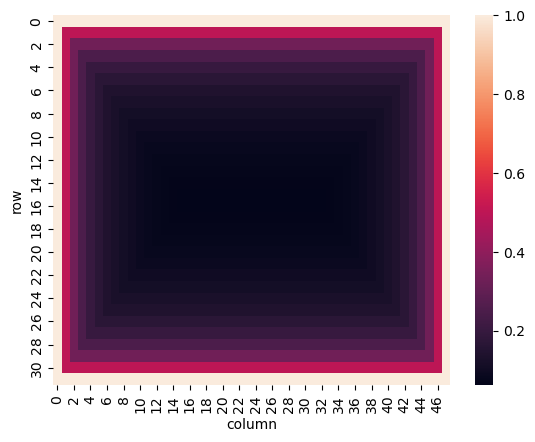

In [85]:
_, ax = plt.subplots()
sns.heatmap(dists, ax = ax)
ax.set_xlabel("column")
ax.set_ylabel("row")

# Exercise 1

Currently, our data looks just like a lot of _numbers_ ; obviously, they do not really make sense when considered individually. The most common way to make sense of such a dataset is to **visualise** it graphically.

Indeed, when starting to work with a new dataset the first step is very often looking at it in its entirety via various visualisations, so consider Exercise 1 as a generic "protocol".  The first part of this exercise will be to _plot_ the data in various ways, then later use automated methods to _regroup_ similar parts of the data.

## 1a. Plotting individual time series

Since the data represents **time series**, it makes sense to plot the _number of cells_ for each _time point_. In this exercise, we will do that first for a few selected populations of each plate, and then for all populations of each plate.

### A selection of arbitrary populations

First, let's create a plot for each plate, displaying the time series of the **locations** _(0, 0), (1, 1), (16, 24), (20, 12), (24, 40)_ and _(31, 47)_ :

In [86]:
coords = [(0, 0), (1, 1), (16, 24), (20, 12), (24, 40), (31, 47)]

**Reminder :** The time series of the population located at _(0, 0)_ can be displayed for each plate the following way :

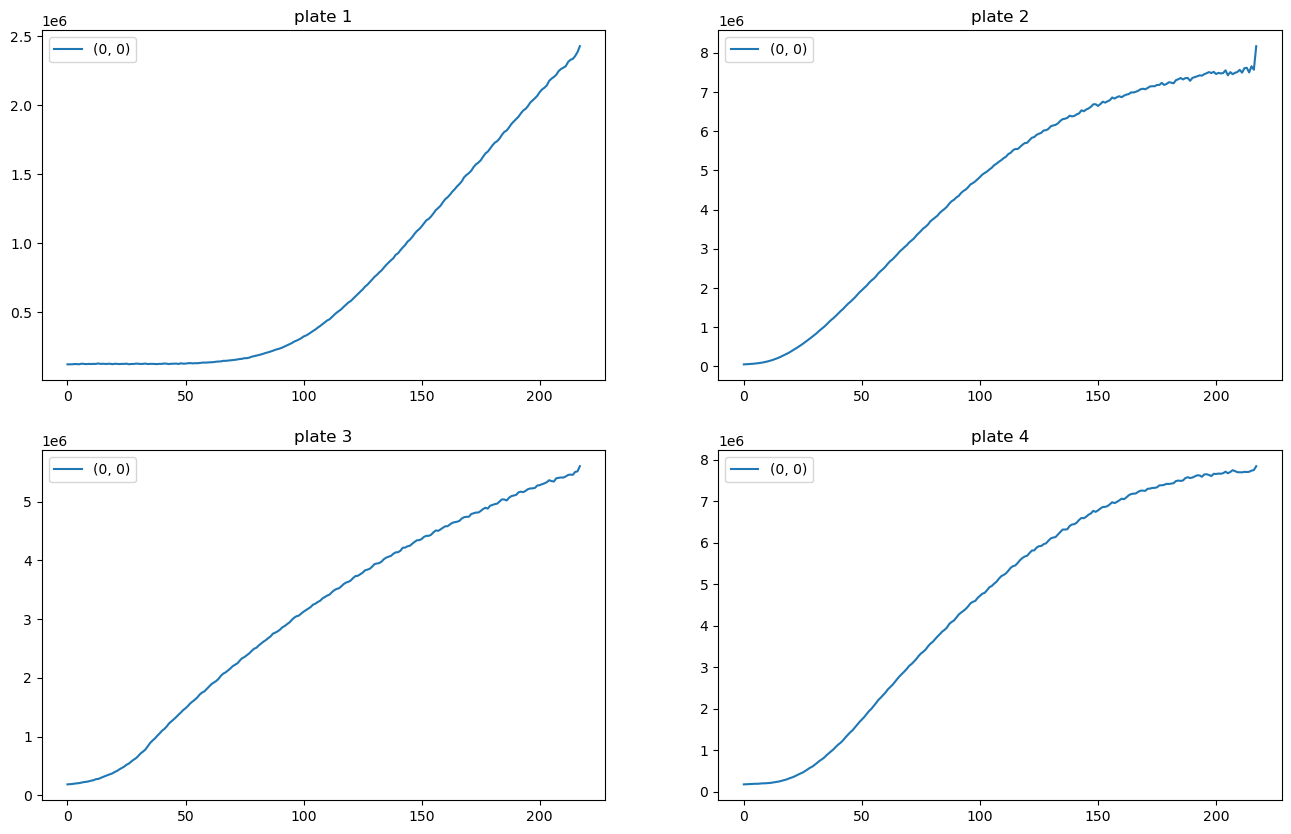

In [87]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for p in range(n_plates):
    axes[p//2, p%2].plot(
        Nt[p, 0, 0],
        label = f"({0}, {0})"
    )
    
    axes[p//2, p%2].set_title(f"plate {p+1}")
    axes[p//2, p%2].legend()

Copy the above code in the cell below, and modify it so that it displays the trajectories of all the coordinates contained in the `coords` variable :

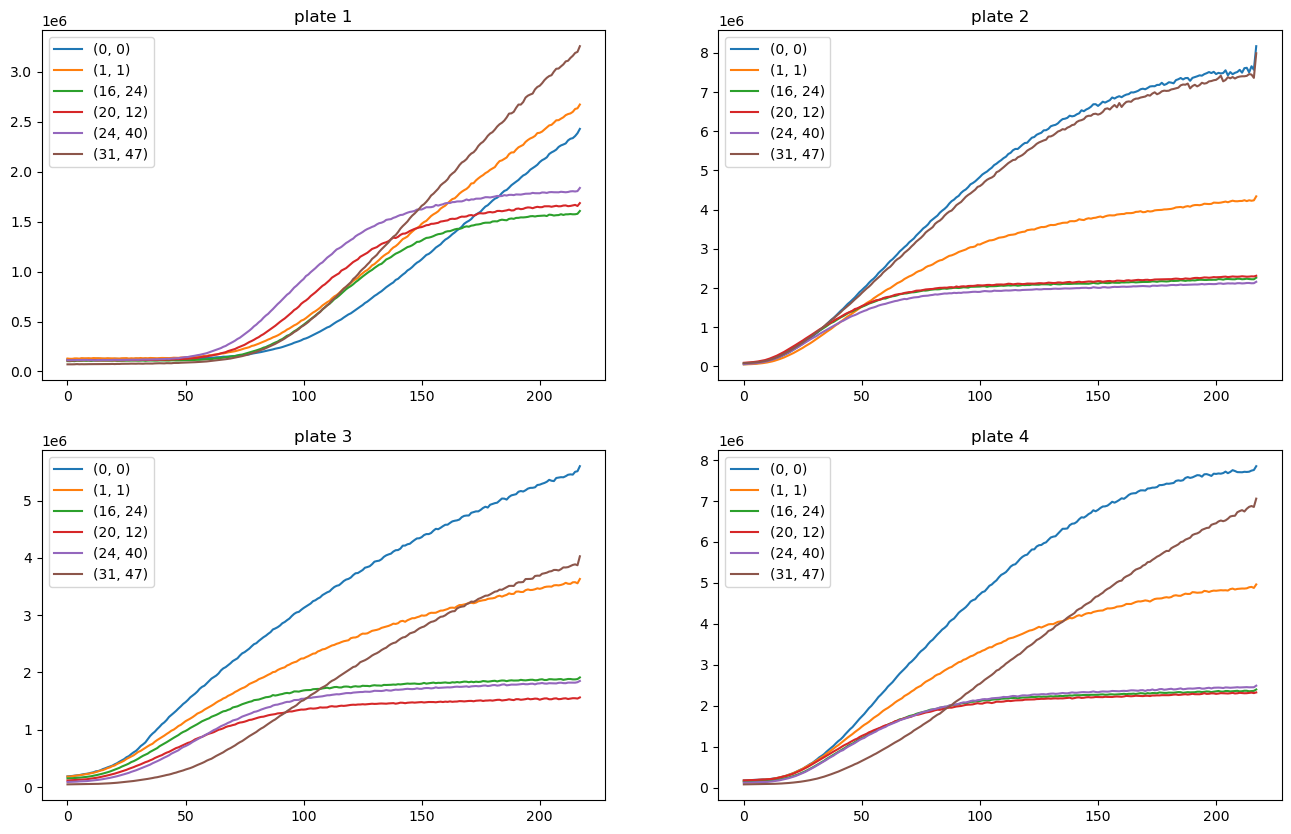

In [88]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for p in range(n_plates):
    for coord in coords:
        axes[p//2, p%2].plot(
            Nt[p, coord[0], coord[1]],
            label = f"({coord[0]}, {coord[1]})"
        )
    
    axes[p//2, p%2].set_title(f"plate {p+1}")
    axes[p//2, p%2].legend()

**Hint :** In the `for` loop iterating through the plates, nest another `for` loop iterating through the `coords` variable, and place the right function calls into that loop.

You should observe that the populations **close to the border** behave very differently than the ones **far from the border**.

#### Adding colour

Add colour to the lines according to the _inverse distance_ of the populations _to the closest border_ (use a gradient from red to black if in doubt) :

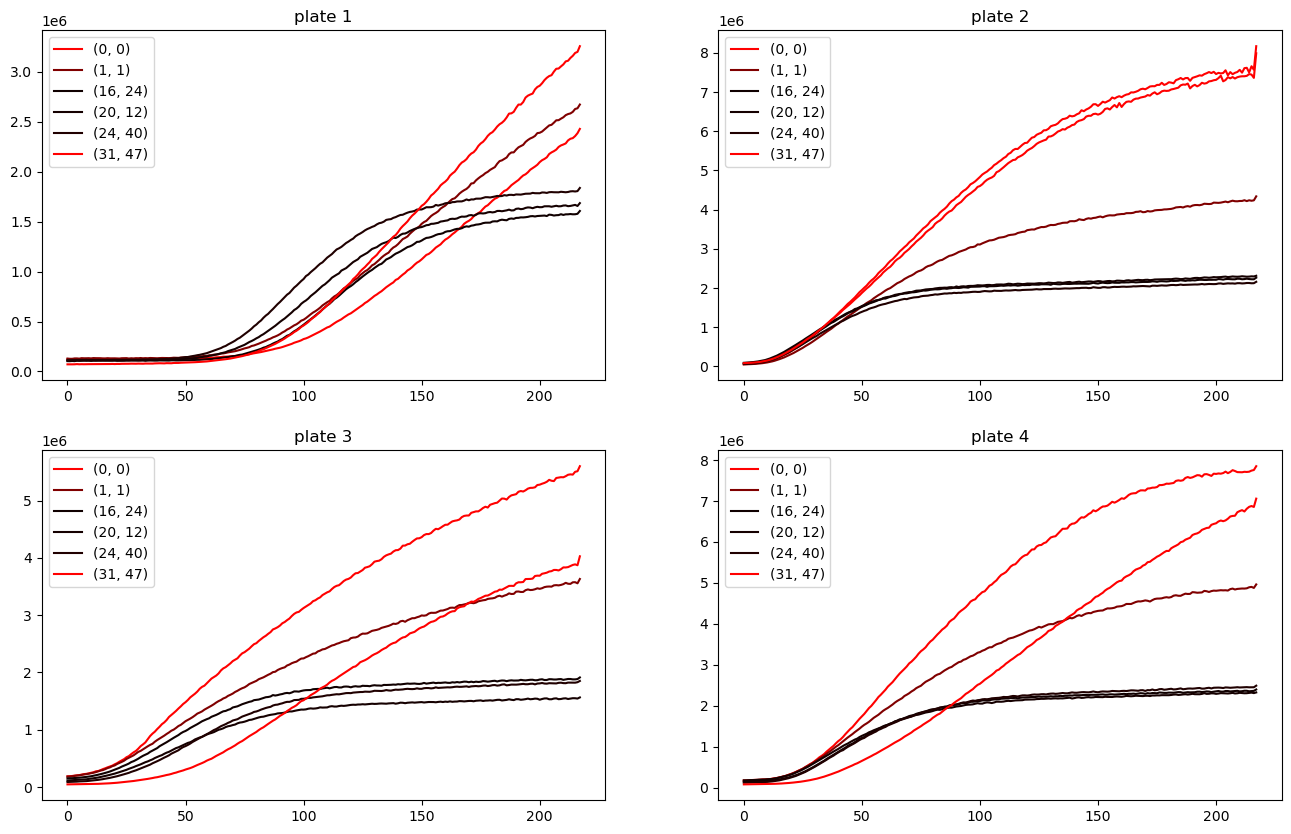

In [89]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for p in range(n_plates):
    for coord in coords:
        axes[p//2, p%2].plot(
            Nt[p, coord[0], coord[1]],
            label = f"({coord[0]}, {coord[1]})",
            color = (dists[coord[0], coord[1]], 0, 0)
        )
    
    axes[p//2, p%2].set_title(f"plate {p+1}")
    axes[p//2, p%2].legend()

**Hint 1 :** The `dists` variable maps for every location in a plate, the value you seek. So the _inverse distance_ of the location _(r, c)_ _to the closest border_ can be obtained as `dists[r, c]`.
(Note that these values are between 0 and 1.)

**Hint 2 :** _PyPlot_'s `plot` function has a `color` parametre which you can use the following way : a colour is represented as a combination of **RGB** values, which means a gradient from black to red can be obtained by varying the red component of the RGB triplet you provide to the `color` parametre. [More on colours here.](https://matplotlib.org/stable/tutorials/colors/colors.html "Really, read the docs !")
A few examples :
* **black** is _(0, 0, 0)_
* **red** is _(1, 0, 0)_
* **cyan** is _(0, 1, 1)_
* **orange** is _(1, 0.5, 0)_

### All the trajectories

Now plot **all** trajectories of each plate instead of just the few arbitrary coordinates from above, with the same colour scheme :

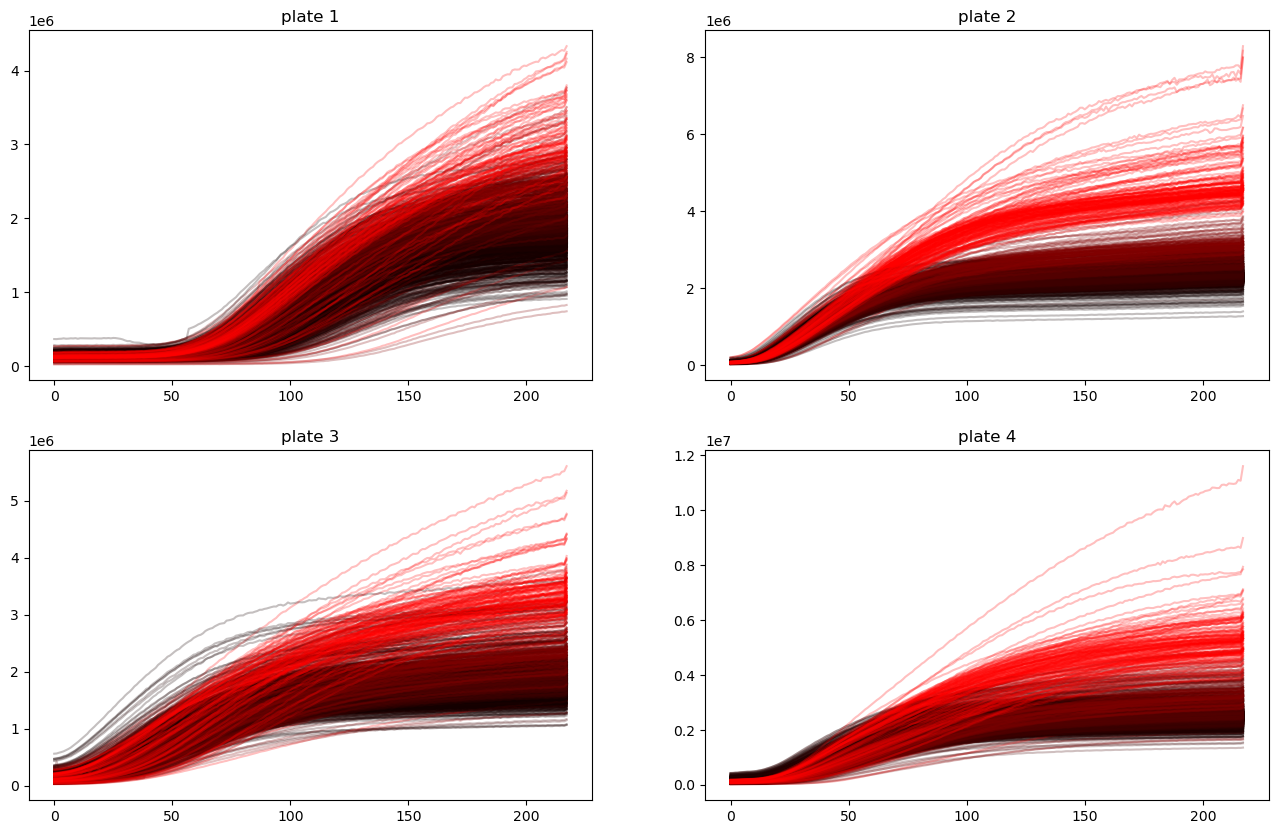

In [90]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for r in range(n_rows): 
    for c in range(n_columns):
        for p in range(n_plates):
            axes[p//2, p%2].plot(
                Nt[p, r, c],
                # label = f"({r}, {c})",
                color = (dists[r, c], 0, 0),
                alpha = 0.25
            )
    
            axes[p//2, p%2].set_title(f"plate {p+1}")
            # axes[p//2, p%2].legend() # this almost fried my computer

(By the way, it is normal for this plot to take more time to generate.)

**Note :** As this plot gets messy very fast, you may want to add transparency to the lines. Use the `alpha` parametre of the `plot` function for that (0 means fully transparent, 1 means fully opaque).

#### Comment here on how the plates differ

**Answer :** On some plates, being near the border has a bigger impact in the growth. Some also grow overall a bit quicker and bigger than others, comparing for example plates 2 and 4.

## 1b. Plotting statistics

As can be seen from the trajectories, there is a **high diversity** on each plate. Since the plates are two-dimensional, there are two ways to display it : as a _histogram_ or as a _heatmap_.

### Histograms

A common way to summarise datasets is to use a **histogram** ; _PyPlot_ has a function called [hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) which can plot a histogram for you, if provided with a 1-dimensional array of values.

This function can be used the following way, if for example you want to plot a histogram of the cell numbers of each plate at coordinate _(0, 0)_ :

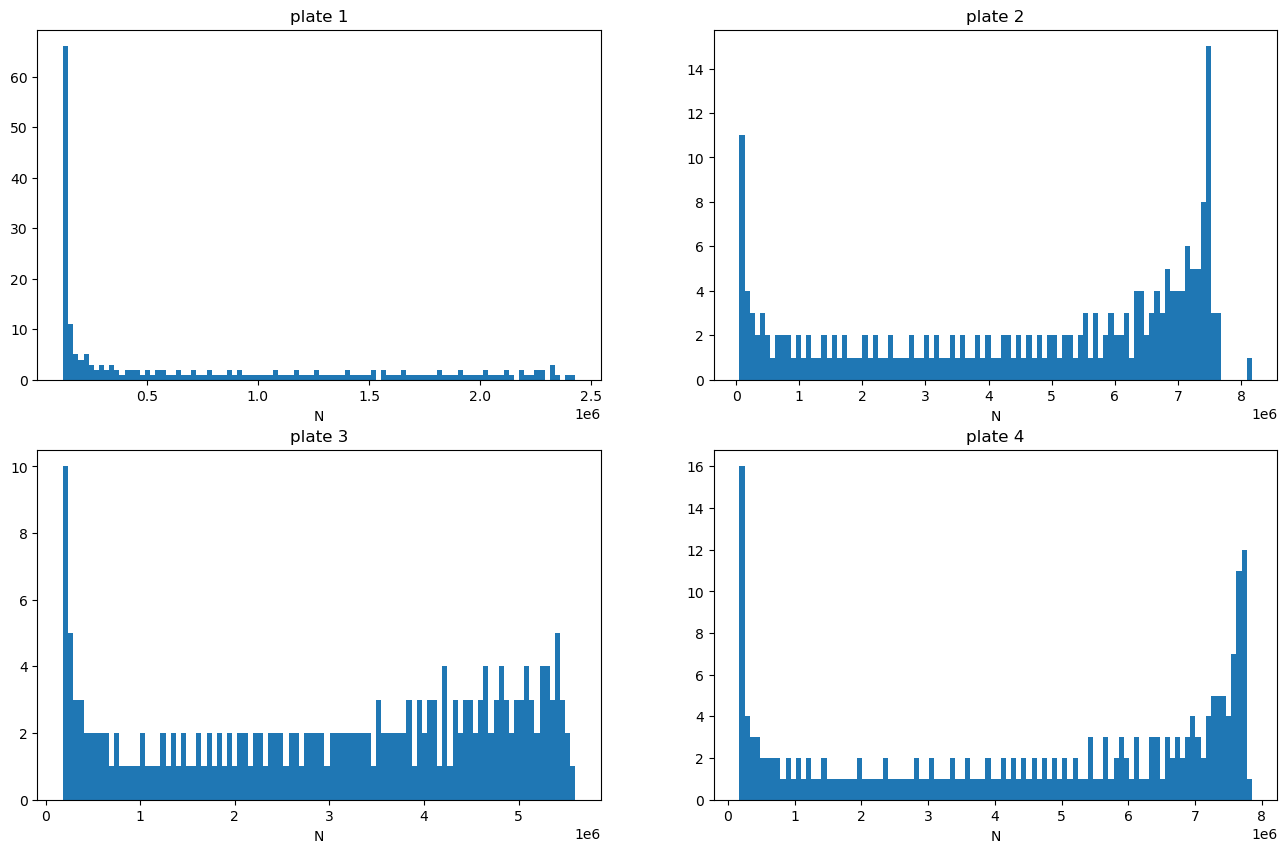

In [91]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for p in range(n_plates):
    axes[p//2, p%2].hist(data[p, 0, 0], bins = 100)
    axes[p//2, p%2].set_title(f"plate {p+1}")
    axes[p//2, p%2].set_xlabel("N")

Plot here for each plate a histogram of the number of cells at **time 0** (use 100 bins) :

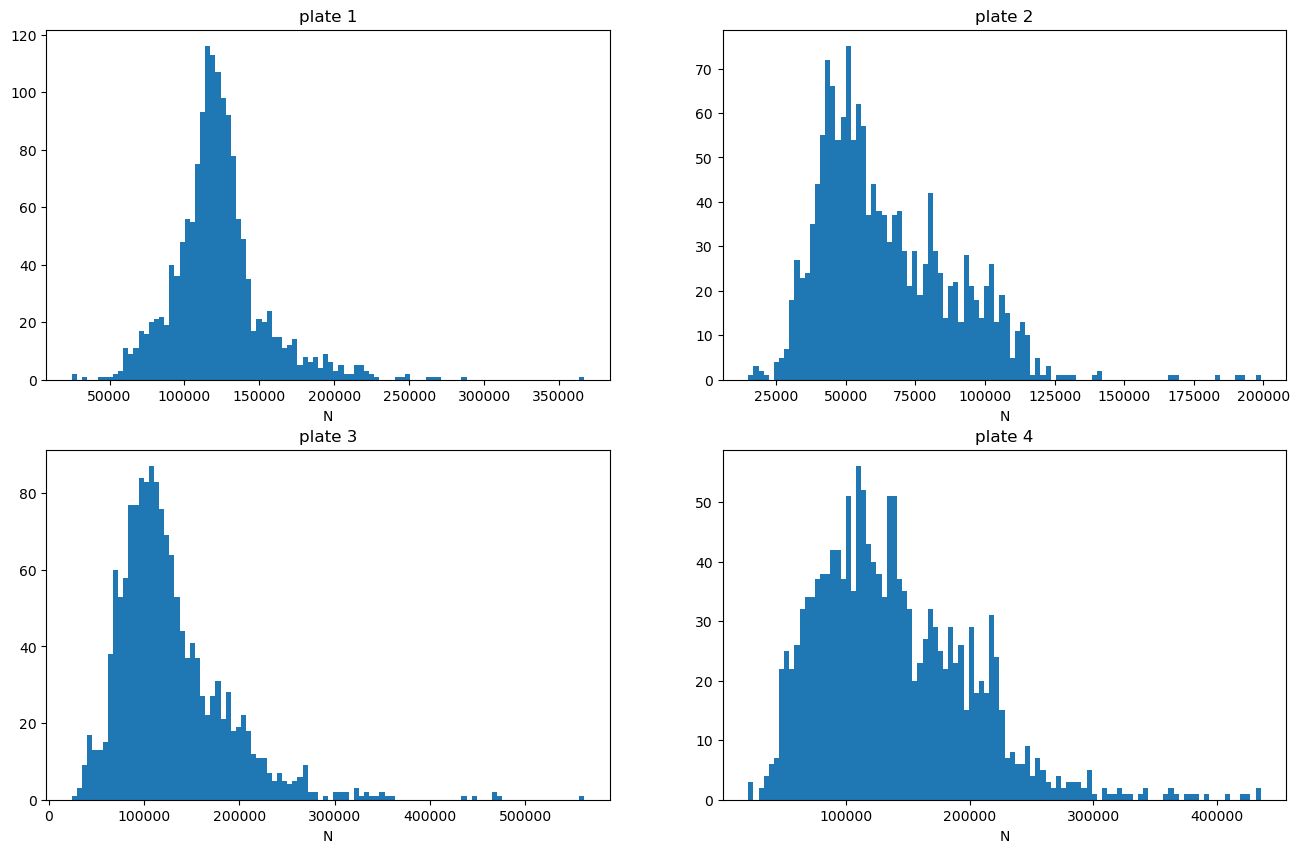

In [92]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for p in range(n_plates):
    axes[p//2, p%2].hist(data[p, :, :, 0].reshape(-1), bins = 100)
    axes[p//2, p%2].set_title(f"plate {p+1}")
    axes[p//2, p%2].set_xlabel("N")

and at **the last time point** :

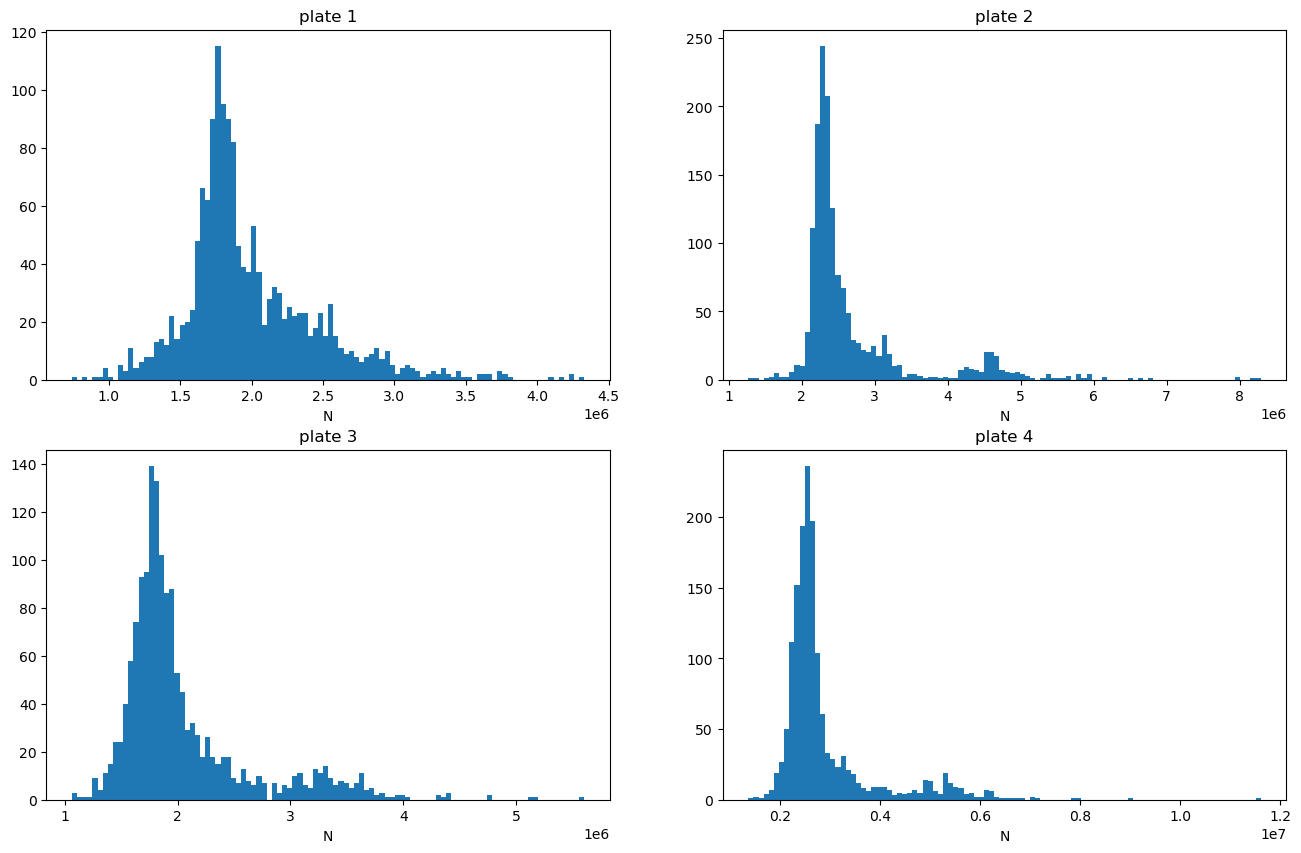

In [93]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

for p in range(n_plates):
    axes[p//2, p%2].hist(data[p, :, :, -1].reshape(-1), bins = 100)
    axes[p//2, p%2].set_title(f"plate {p+1}")
    axes[p//2, p%2].set_xlabel("N")

**Hint :** A time slice of the data is a 2x2 matrix, and you need a 1-dimensional array. Use the `reshape` method to make that transformation.

#### Comment here on how the variance changes between the two times

**Answer :** The scale is getting bigger, so at first it is hard grasp, but the variance increase towards the end.

#### Comment here on what the outliers at the last time point represent, on plates 2-4

**Answer :** The effect of the nearby border is visible in these plates.

### Heatmaps

Another common way, particularly relevant for 2-dimensional data such as a grid, is to visualise it as a **heatmap** ; though _PyPlot_'s function called `imshow` can be used for that purpose, the _seaborn_ module has a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html "Again, read the docs ! ;)") function which is much more powerful.

Plot here for each plate a heatmap of the number of cells at **time 0** :

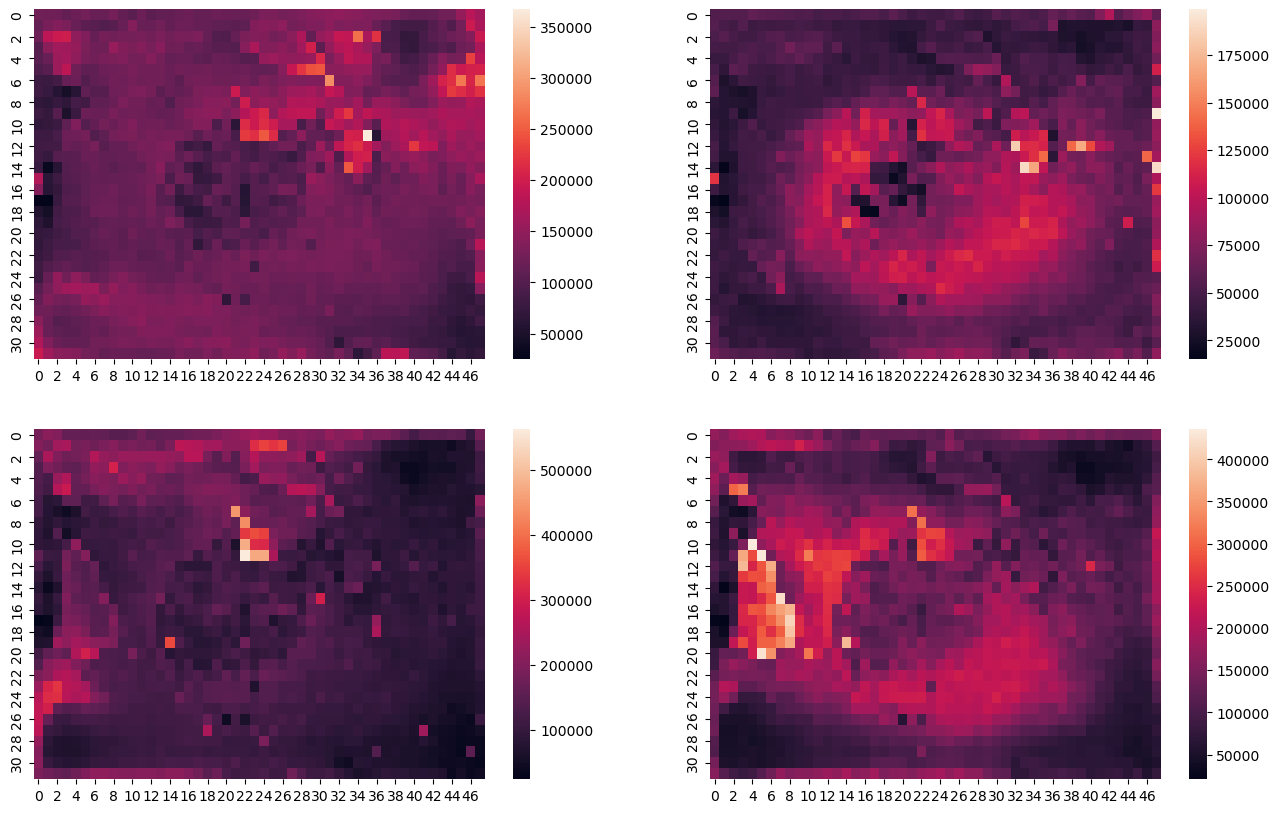

In [94]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

plate = 0
for ax in axes.flat:
    sns.heatmap(data[plate, :, :, 0], ax = ax)
    plate += 1

and at **the last time point** :

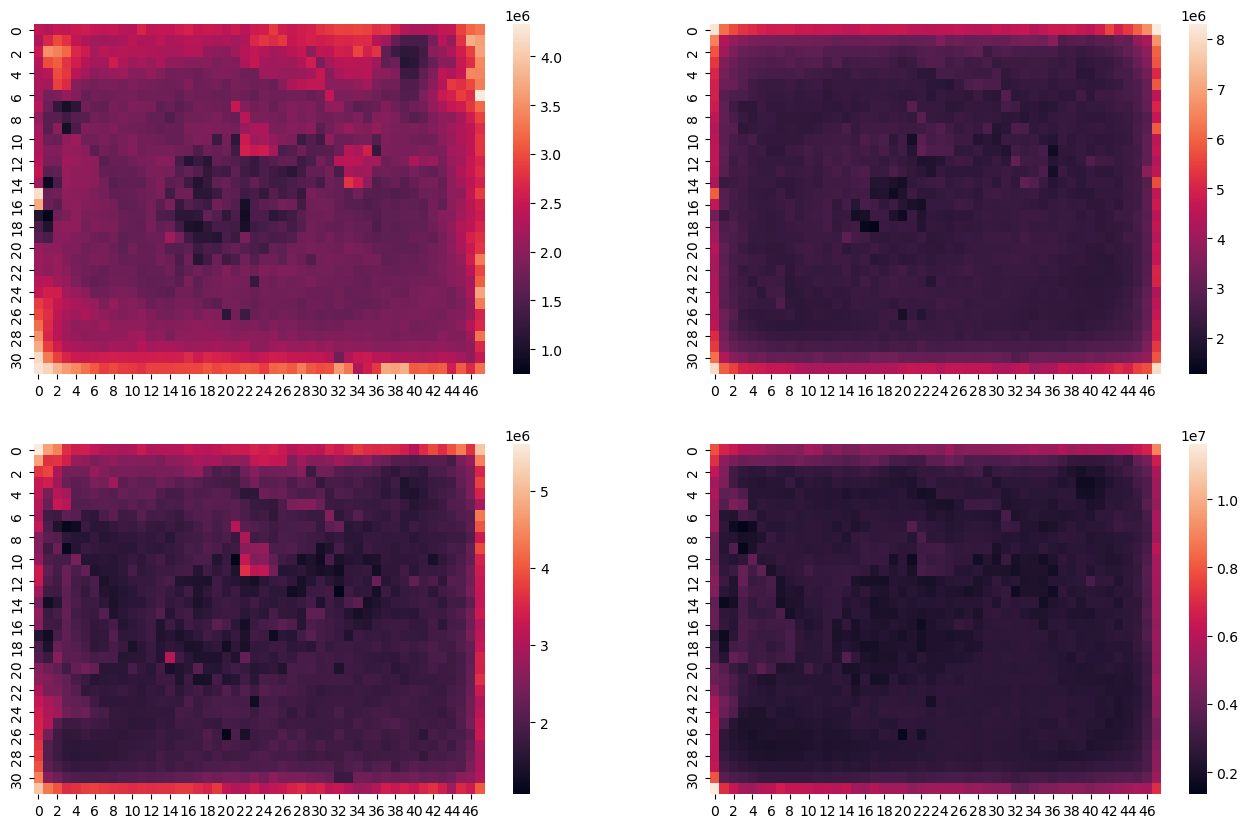

In [95]:
_, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))

plate = 0
for ax in axes.flat:
    sns.heatmap(data[plate, :, :, -1], ax = ax)
    plate += 1

#### Comment here on how the structure of the sizes differ between the two times

**Answer :** Again the scale is deceiving us, the growth is ten times amount in the end than it was in the beginning.

## 1c. Dimensionality reduction and clustering

It is fortunate that we can use intuition such as the distance to the border of the plate, to distinguish different time series. But this kind of intuition does not allow us to go further into categorising the data.

The standard technique for investigating data in an automated fashion is to first **reduce its dimensionality** and then to run a **clustering** algorithm, allowing us to group similar data.

### PCA

#### All plates

Let's start with dimensionality reduction ; one very common algorithm that allows that is **PCA**. We can use it on the whole data regardless of the plate, with _two components_, and project the data into the new space (read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html "Docs often have an example section.") to understand how the transformation to a new space is performed) :

In [96]:
pca_all = pd.DataFrame(
    data    = PCA(n_components = 2).fit_transform(Nt.T),
    columns = ["component 1", "component 2"],
    index   = Nt.columns
)

Having a _two components_ decomposition means we decompose our set of time series as a **set of points in a 2D space**. This means, we can plot them as a _scatter plot_ ; when doing that, try to colour each point according to the plate it belongs to :

<Axes: xlabel='component 1', ylabel='component 2'>

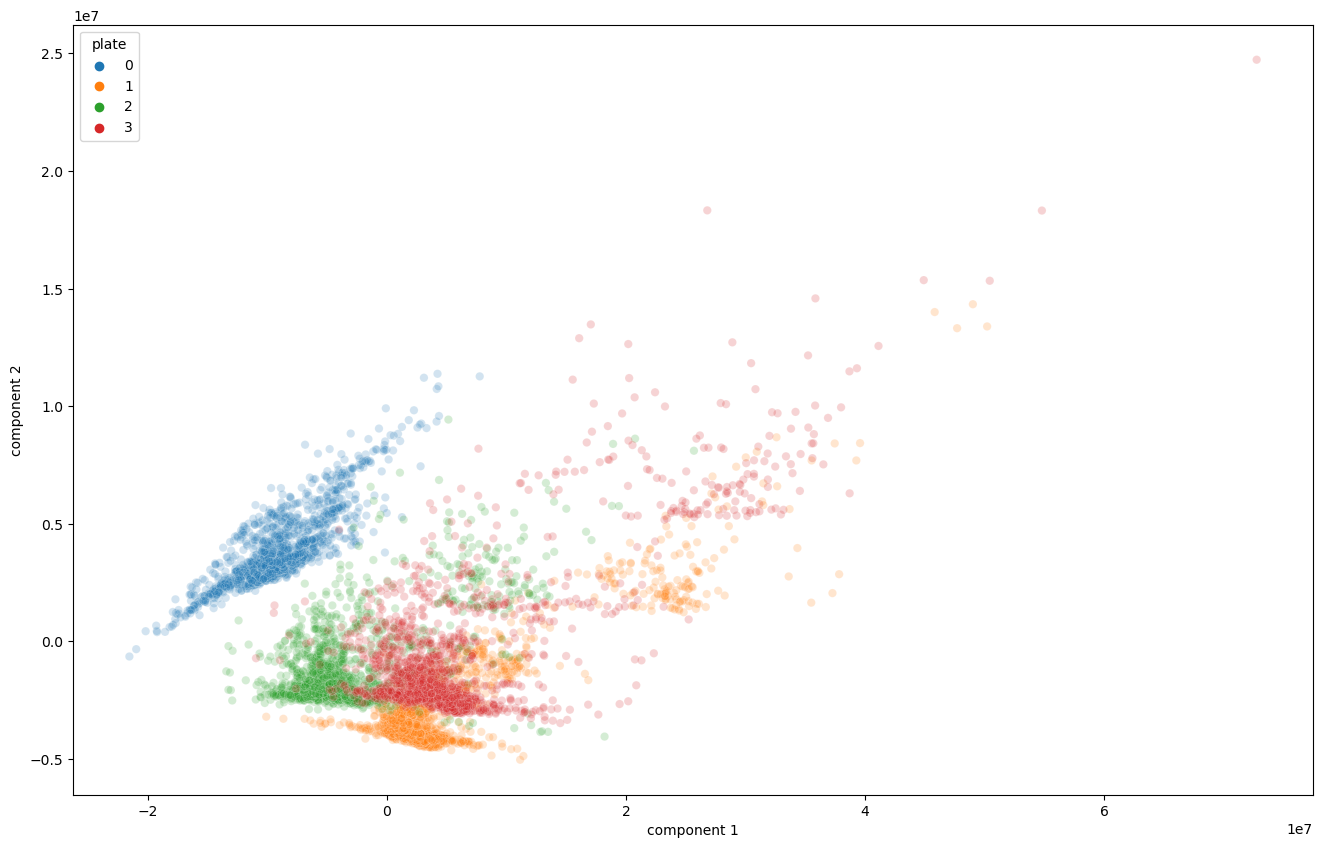

In [97]:
_, ax = plt.subplots(figsize = (16, 10))

sns.scatterplot(
    x       = "component 1",
    y       = "component 2",
    hue     = "plate",
    data    = pca_all.reset_index(level = 0),
    palette = sns.color_palette(n_colors = n_plates),
    alpha   = 0.2,
    ax      = ax
)

#### Comment here on how well the plates are separable

**Answer :** Plate labeled as 0 is more distinctly different from the others, separating 1, 2 and 3 from each other would be harder to group by looking at them without the color.

#### Individual plates

Instead of grouping the whole data from all plates, this time, reduce the dimensionality of each plate individually :

In [98]:
pca_indv_plates = list()
for p in range(n_plates):
    pca_plate = pd.DataFrame(
        data    = PCA(n_components = 2).fit_transform(Nt[p].T),
        columns = ["component 1", "component 2"],
        index   = Nt[p].columns
        )
    pca_indv_plates.append(pca_plate.reset_index())

Plot the decompositions for each plate on a different _scatter plot_, but this time give the colours according to the **distance to the border of the plate** :

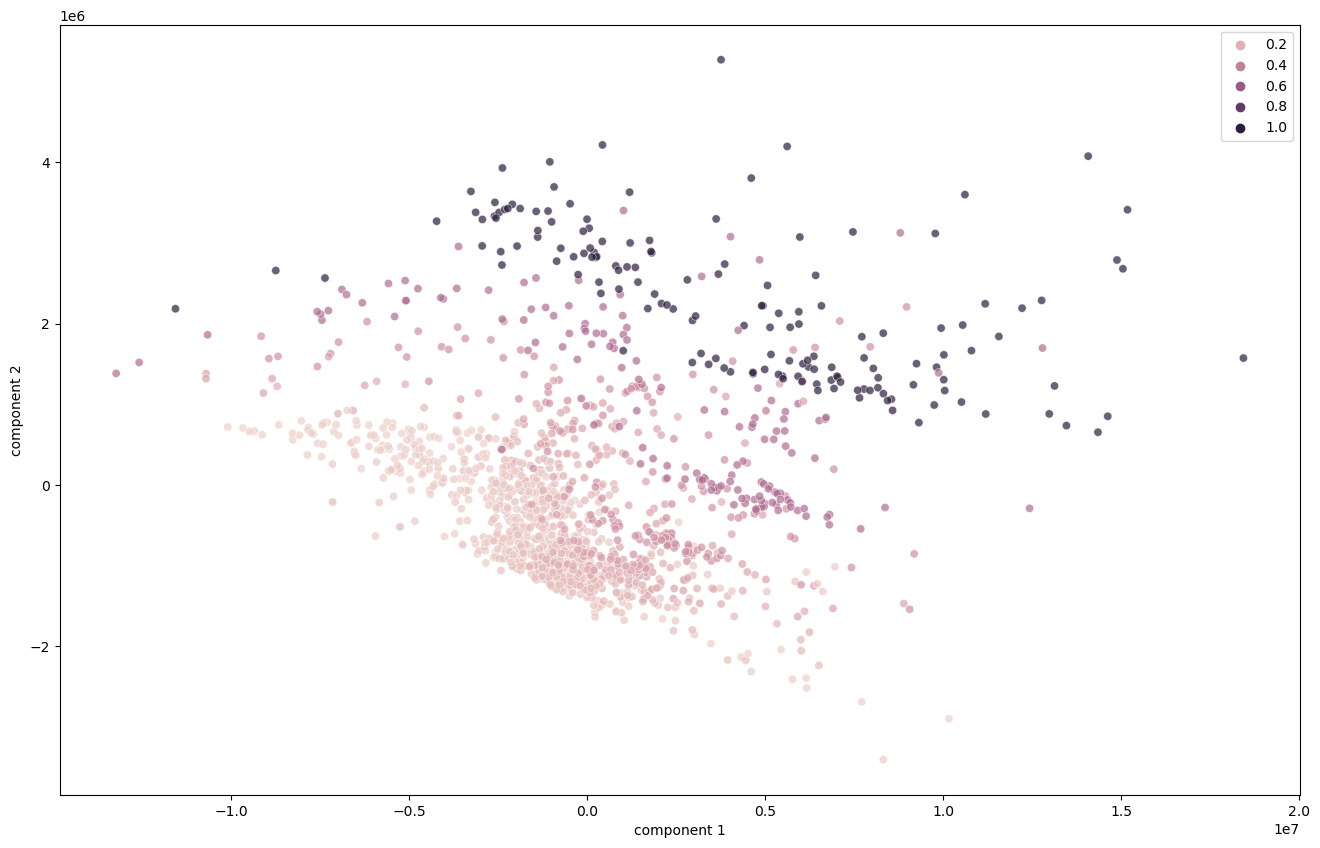

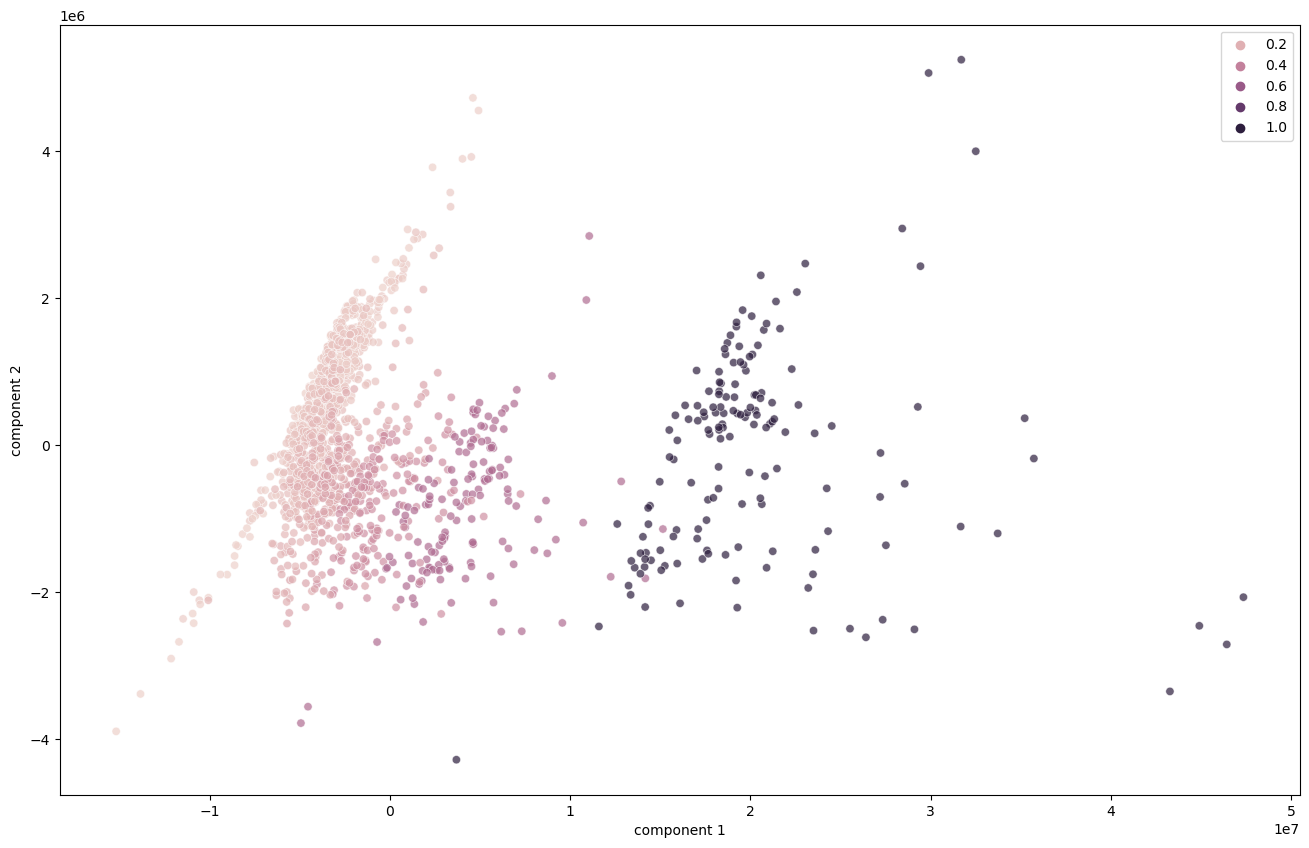

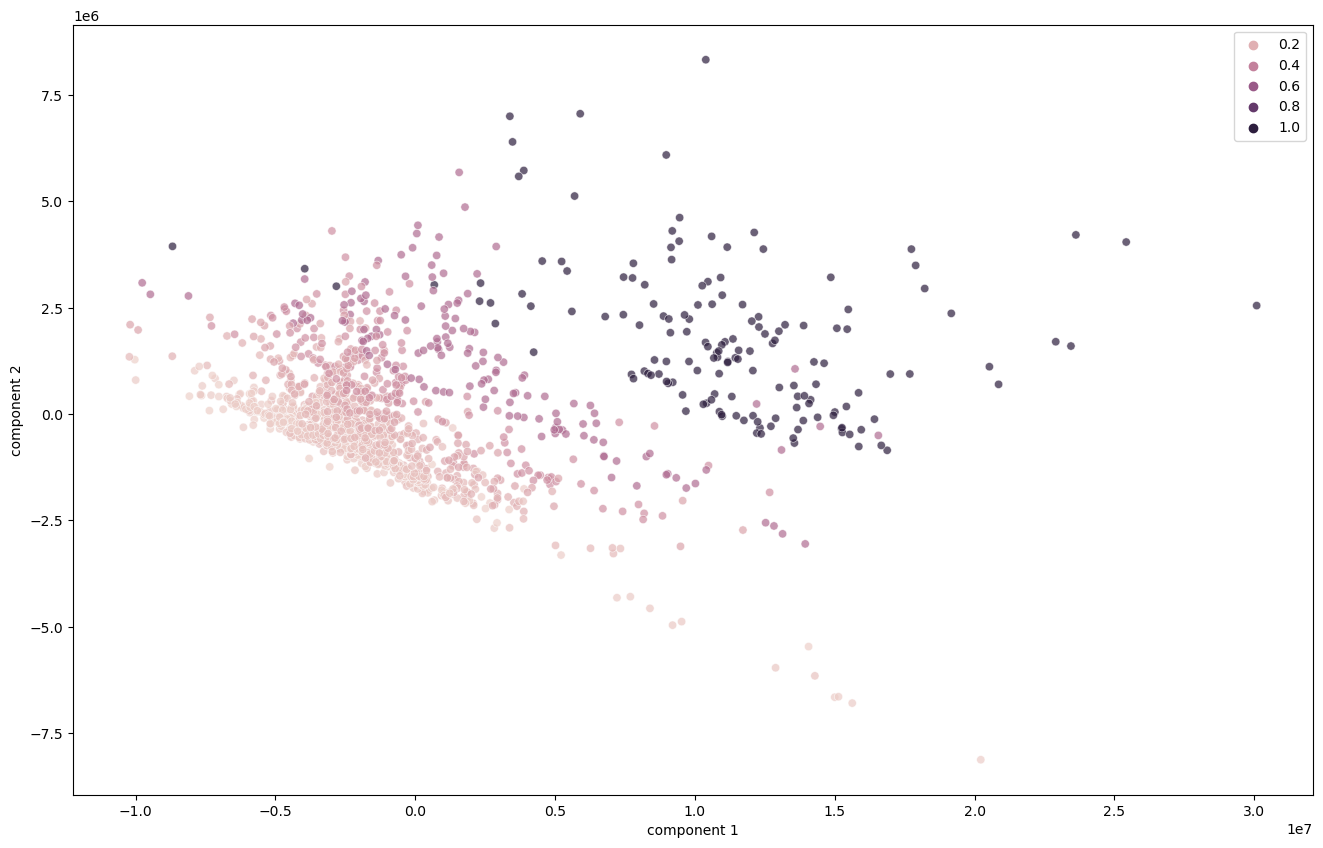

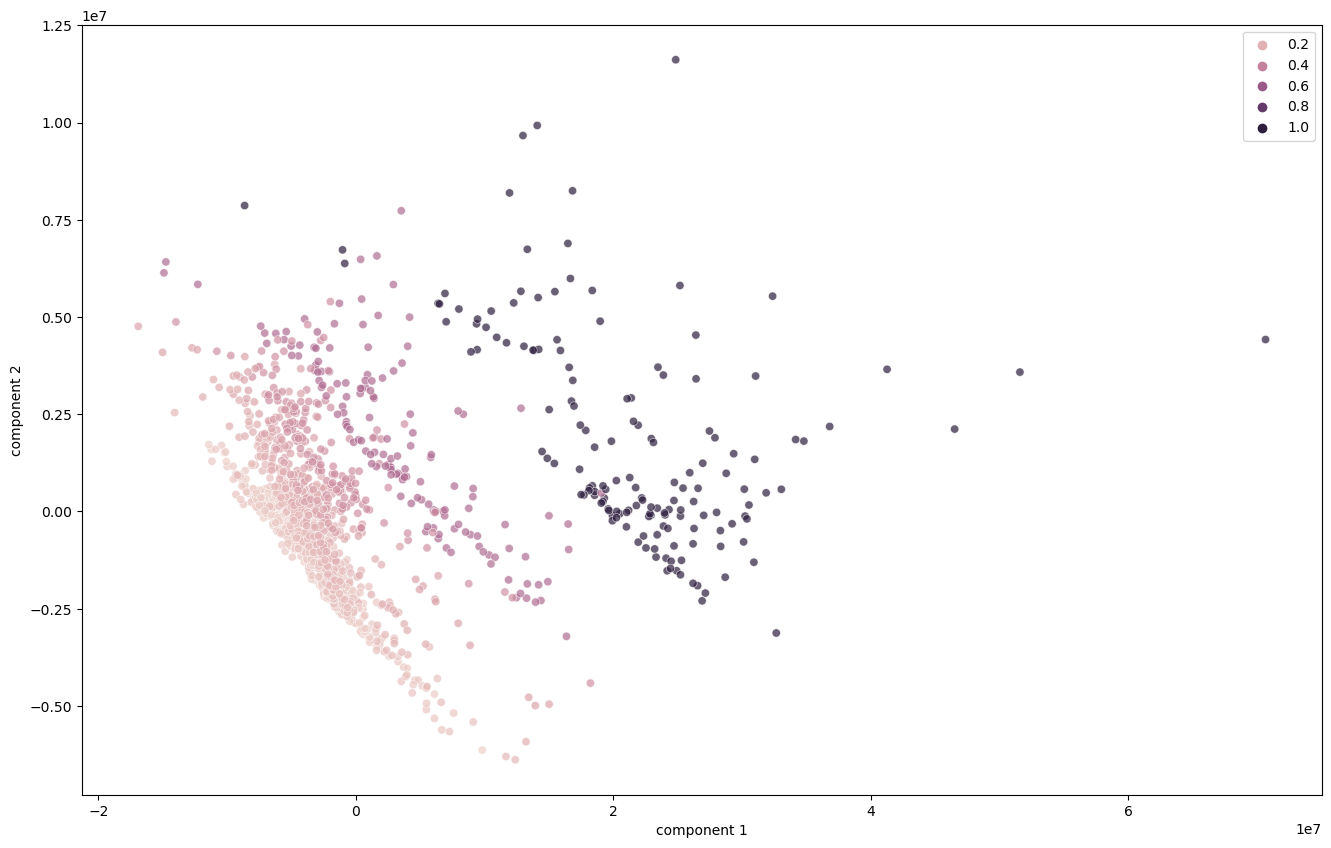

In [99]:
for pld in pca_indv_plates:
    _, ax = plt.subplots(figsize = (16, 10))
    
    sns.scatterplot(
        x       = "component 1",
        y       = "component 2",
        hue     = dists.reshape(-1),
        data    = pld,
        alpha   = 0.7,
        ax      = ax
    )

**Hint :** You can pass the `dists` variable to the _hue_ parametre, provided you linearise it into a 1-dimensional array.

#### Comment here on how well the populations are separable

**Answer :** Especially on the last plate, the populations are quite separable.

### t-SNE (bonus exercise)

Another very popular algorithm for dimensionality reduction is **t-SNE** ; it is substantially slower than PCA, but in turn offers often better performances. Repeat what you did with PCA but use this time t-SNE (the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) shows it works the same way than for the previous exercise) :

In [100]:
tsne_all = pd.DataFrame(
    data = TSNE(n_components=2, random_state=666).fit_transform(Nt.T),
    columns = ["component 1", "component 2"],
    index = Nt.columns
)

<Axes: xlabel='component 1', ylabel='component 2'>

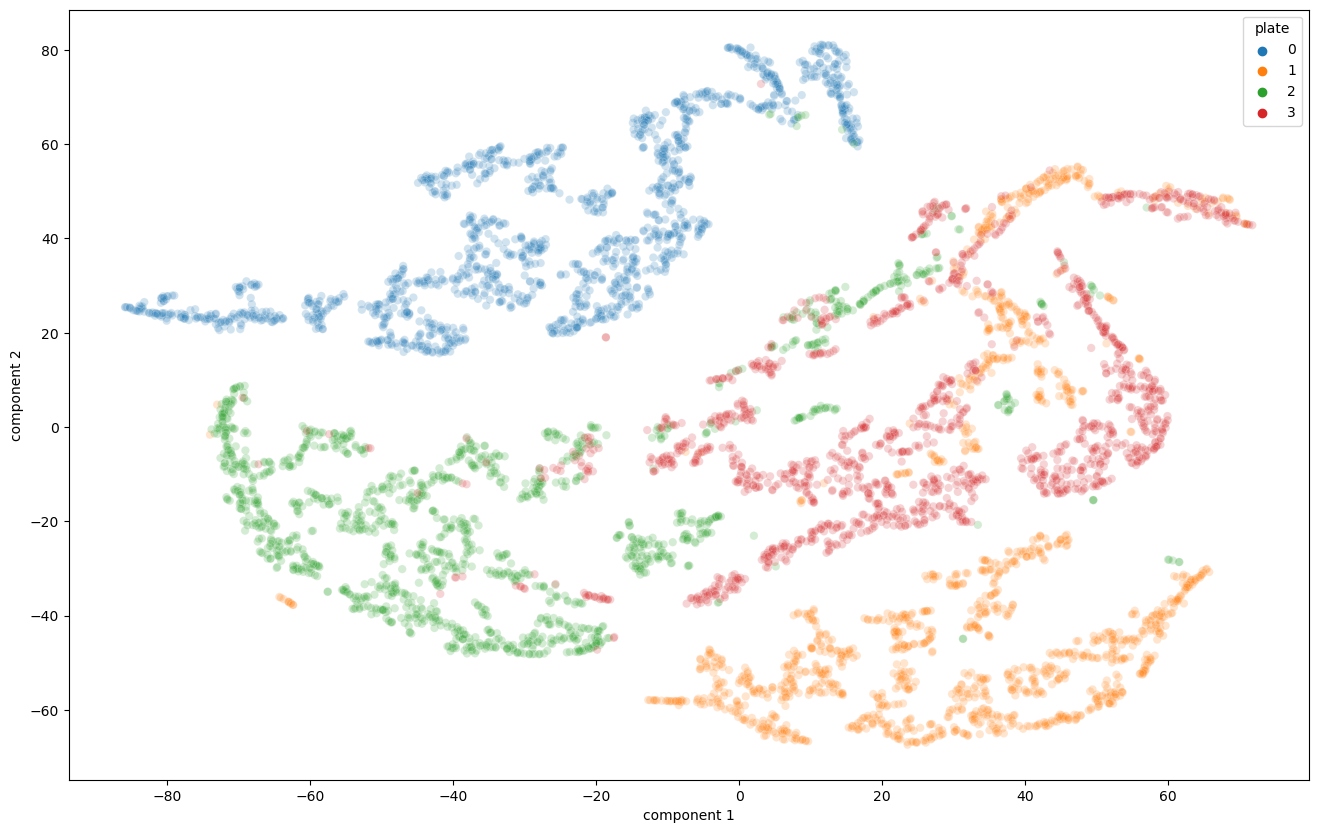

In [101]:
_, ax = plt.subplots(figsize = (16, 10))

sns.scatterplot(
    x       = "component 1",
    y       = "component 2",
    hue     = "plate",
    data    = tsne_all.reset_index(level = 0),
    palette = sns.color_palette(n_colors = n_plates),
    alpha   = 0.2,
    ax      = ax
)

#### Comment here on how the performances of t-SNE compete with PCA

**Answer :** Woooooow what?? Well, it was definitely slower and also the results seem to me almost like on a curver surface. The different plates are more separated though, again the plate labeled 0 being the most different.

### K-Means (bonus exercise)

Until here we made (again !) some assumptions on how various aspects of the data can be separated or regrouped : for example, we set colours according to which plate a point belongs to, or where it is placed on a plate. But how about avoiding that step too ? 

There is a set of **clustering** algorithms that allow us to do that ; **K-Means** is one of them. Unfortunately, these algorithms may run quite slowly if subjected to too many dimensions ; this is why we try to reduce it beforehand.

In this part of the exercise, try to run K-means on one of the sets using all plate data from before (either obtained with PCA or t-SNE), and in particular, observe how it behaves if you change the number of clusters (in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) you can find a method analogous to the one you used in the last two exercies) :

In [102]:
pca_all["cluster"] = KMeans(n_clusters = 4).fit_predict(pca_all[["component 1", "component 2"]])

/home/elli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Make a _scatter plot_ as done above, but use the **cluster prediction** as colour :

<Axes: xlabel='component 1', ylabel='component 2'>

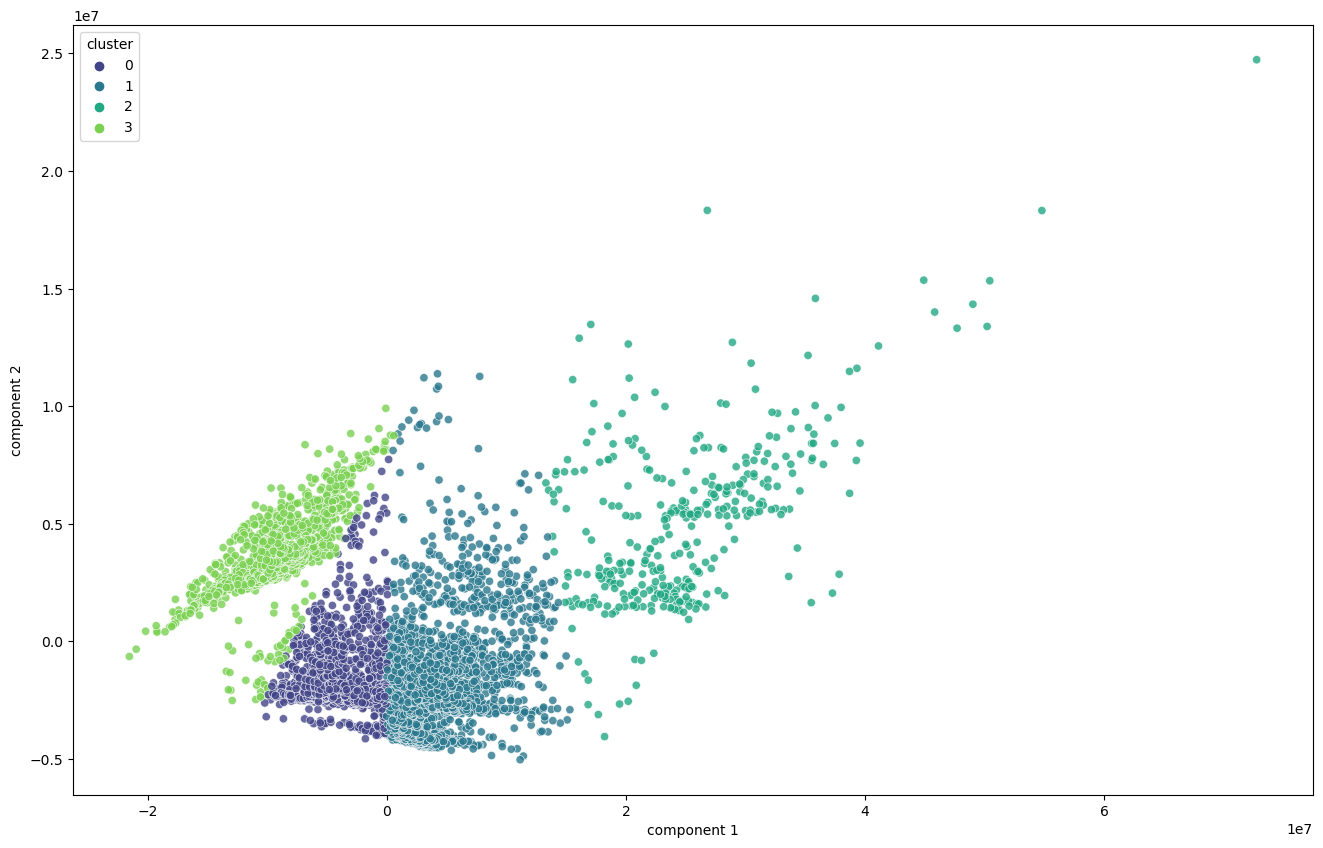

In [103]:
_, ax = plt.subplots(figsize = (16, 10))

sns.scatterplot(
    x = "component 1",
    y = "component 2",
    hue = "cluster",
    data = pca_all.reset_index(level=0),
    palette = sns.color_palette("viridis", n_colors=pca_all["cluster"].nunique()),
    alpha = 0.8,
    ax = ax
)

Repeat this with a data set where the plates are separated (use 5 clusters) :

In [104]:
for pld in pca_indv_plates:
    pld["cluster"] = KMeans(n_clusters = 4).fit_predict(pld[["component 1", "component 2"]])

/home/elli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/elli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/elli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/elli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'au

Their scatter plot :

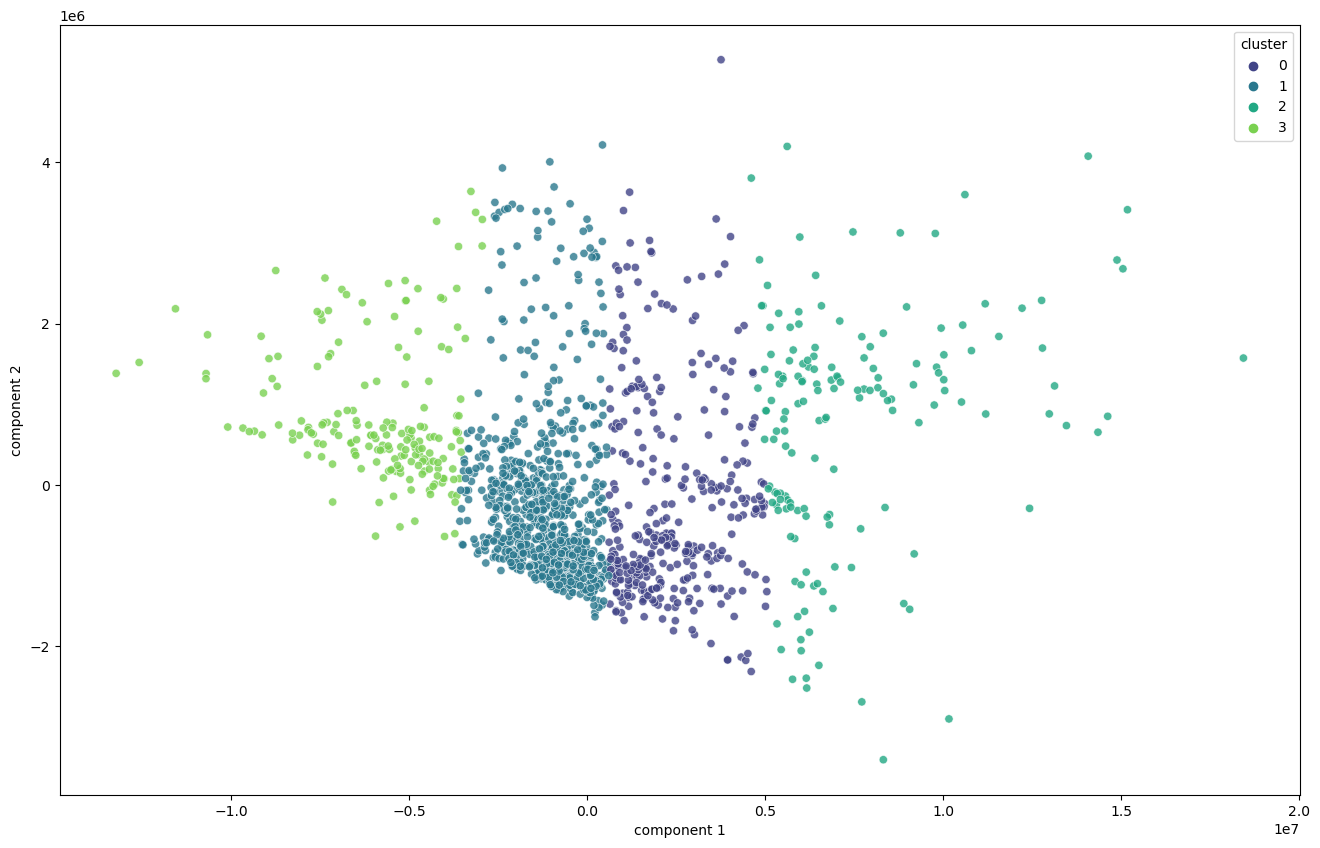

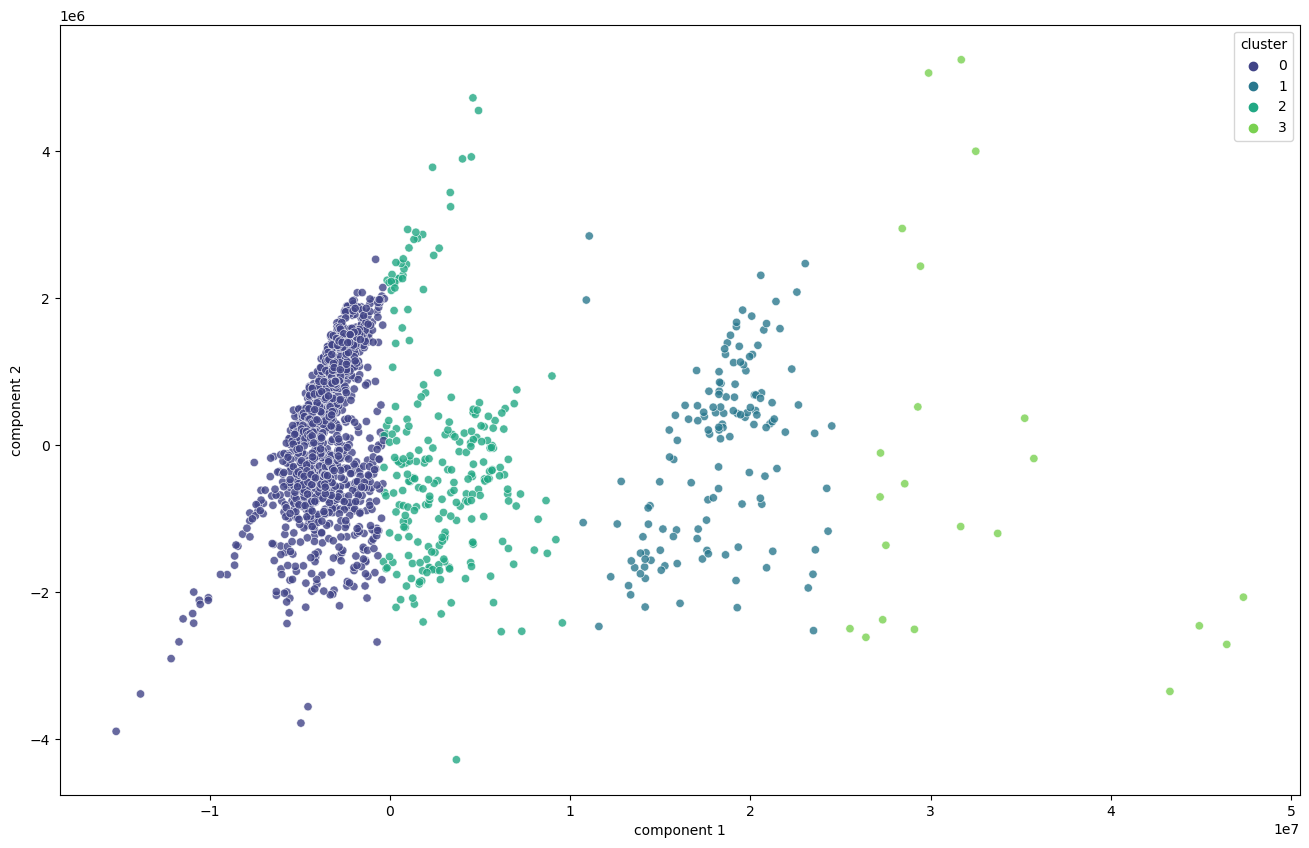

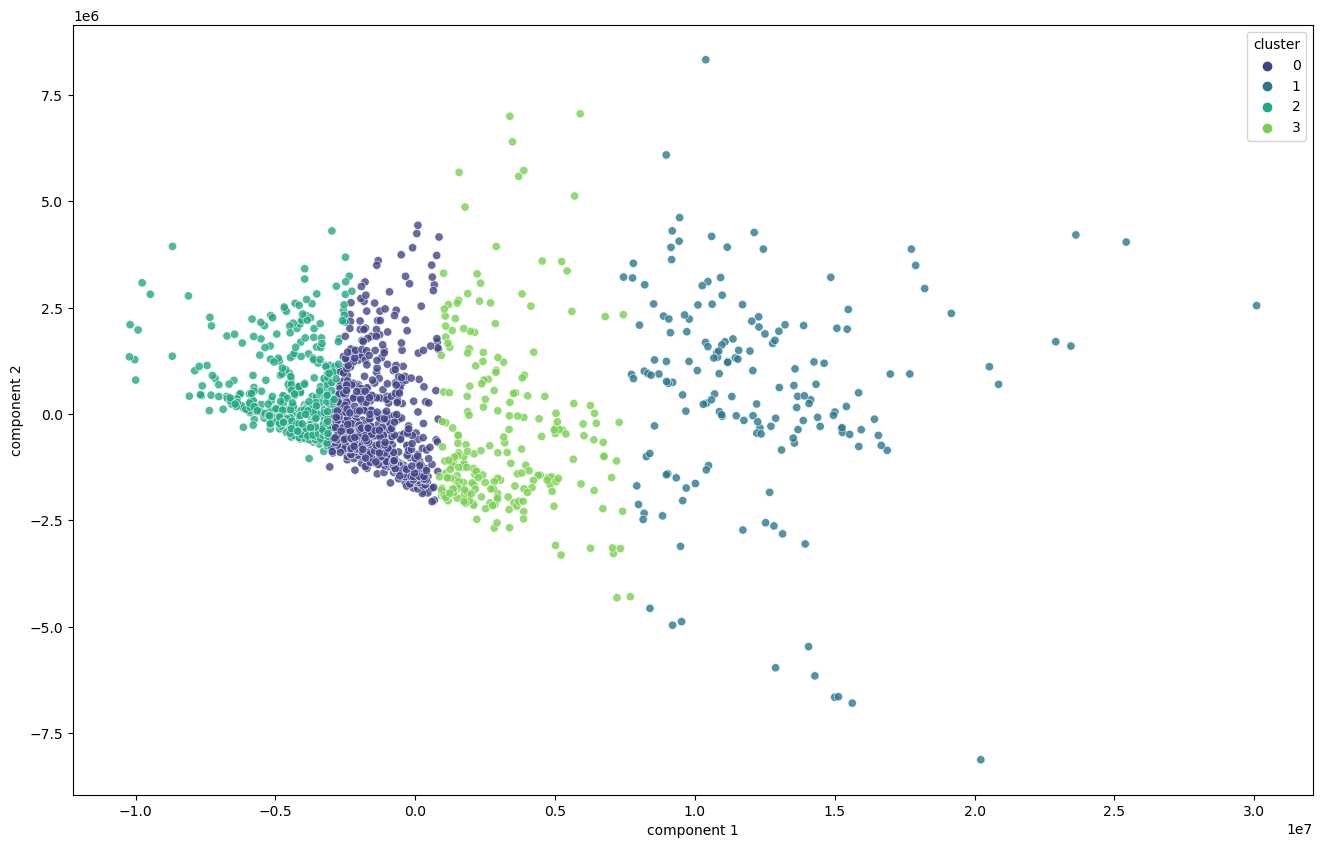

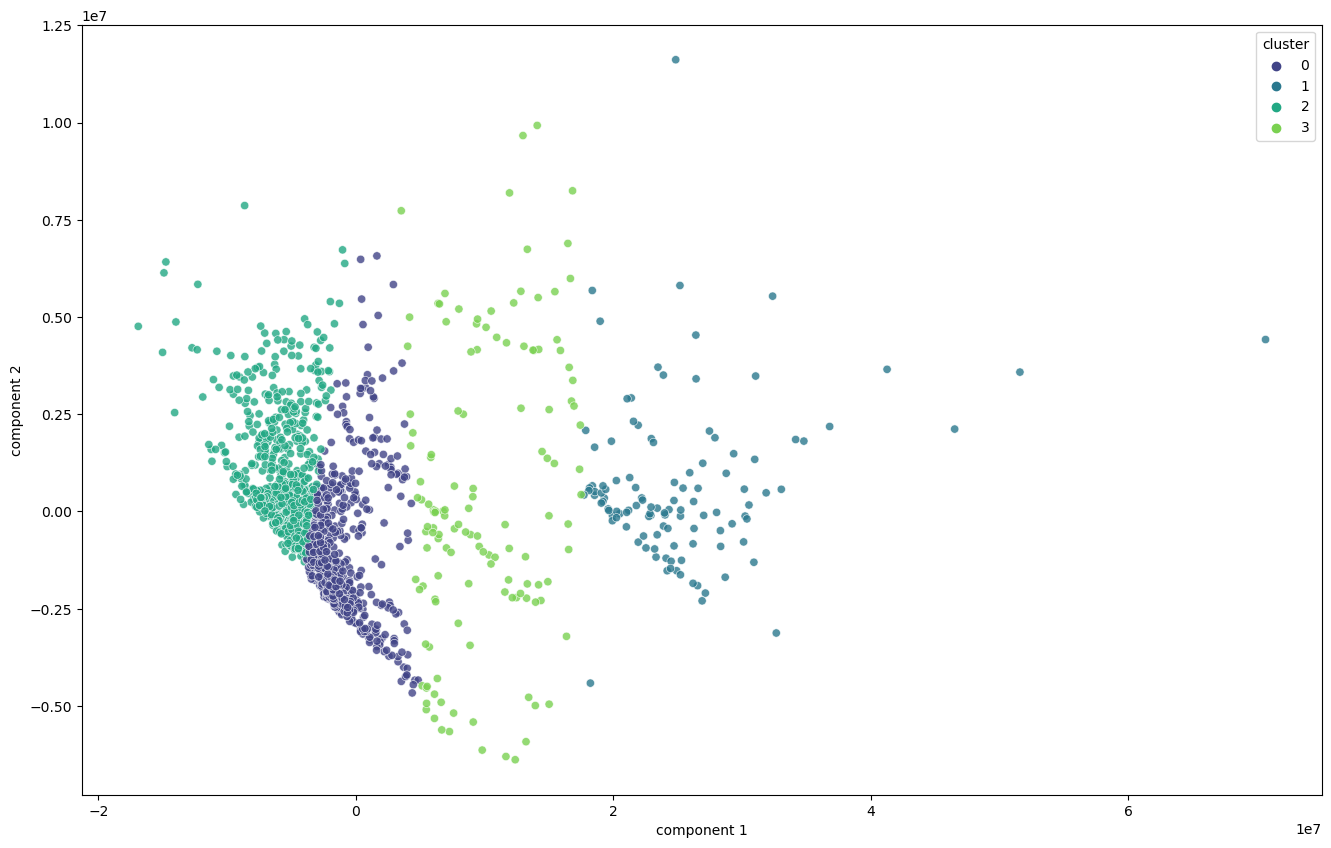

In [105]:
for pld in pca_indv_plates:
    _, ax = plt.subplots(figsize = (16, 10))
    
    sns.scatterplot(
        x = "component 1",
        y = "component 2",
        hue = "cluster",
        data = pld,
        palette = sns.color_palette("viridis", n_colors=pca_all["cluster"].nunique()),
        alpha = 0.8,
        ax = ax
    )

#### Comment here on why the clusters look different from the distance-based ones

**Answer :** K-means minimizes the variance where distance-based is, well, distance based.

# Exercise 2

The previous exercise was about _exploring_ the time series data ; making _sense_ of it. Exercise 2 on the other hand, is about **fitting** the data to a _model_ ; after all, we want to **explain** the data with a formal view, not just compare numbers and features.

The model we choose is a variant of the _generalised logistic curve_ or **Richards' curve**, which is recurrent in biology :
$$
    N(t) = \beta + \frac{L_f}{(1 + \nu e^{-k(t-t_m)})^{1/\nu}}
$$

## 2a. Training : linear fit

The fits for the above model are going to be difficult to perform. In order to learn to use a fitting tool called [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), we will start by fitting a **linear model** :
$$
    N(t) = at + b
$$
The idea of a fit is to find values for the parametres $a$ and $b$ so that the model _fits_ the data we try to fit.

Let's do this for plate 1 at coordinate _(16, 16)_ :

In [106]:
ts = np.arange(n_points)

In [107]:
(a, b), _ = curve_fit(
    f     = lambda t, a, b: a * t + b,
    xdata = ts,
    ydata = Nt[0, 16, 16]
)

and comparing the fit to the actual data :

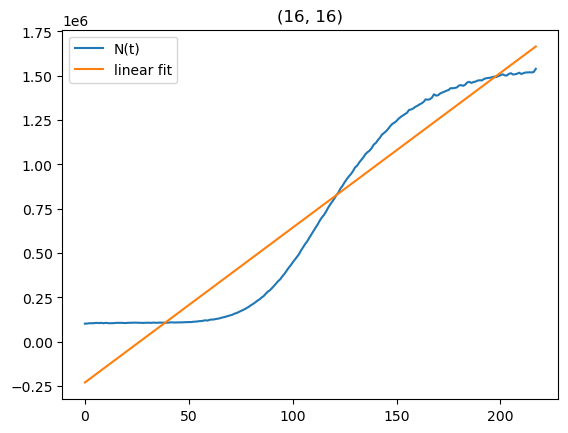

In [108]:
plt.plot(ts, Nt[0, 16, 16], label = "N(t)")
plt.plot(ts, a * ts + b, label = "linear fit")
plt.title(f"({16}, {16})")
plt.legend()

**Note :** I'm providing here a _lambda_ function to the `curve_fit` function (you may want to take time to understand the concept of [anonymous function](https://en.wikipedia.org/wiki/Closure_(computer_programming)#Anonymous_functions "Merci Wikipedia !")), as it allows to create functions on the fly, which represents a linear model $at + b$.

Perform a series of linear fits for the set of coordinates below :

In [109]:
coords = [(0, 0), (1, 1), (16, 24), (20, 12), (24, 40), (31, 47)]

Start by performing the fits, and store the obtained values into this variable :

In [110]:
params = np.empty((len(coords), 2))

In [111]:
ts = np.arange(n_points)
i = 0
for c in coords:
    (a, b), _ = curve_fit(
        f     = lambda t, a, b: a * t + b,
        xdata = ts,
        ydata = Nt[0, c[0], c[1]]
    )
    params[i] = [a, b]
    i += 1

**Hint :** Use a `for` loop to iterate through the coordinates, and store the computed parametres into the `params` variable directly.

Now plot the linear fits against the data as done above, for every coordinate (use 2 rows and 3 columns) :

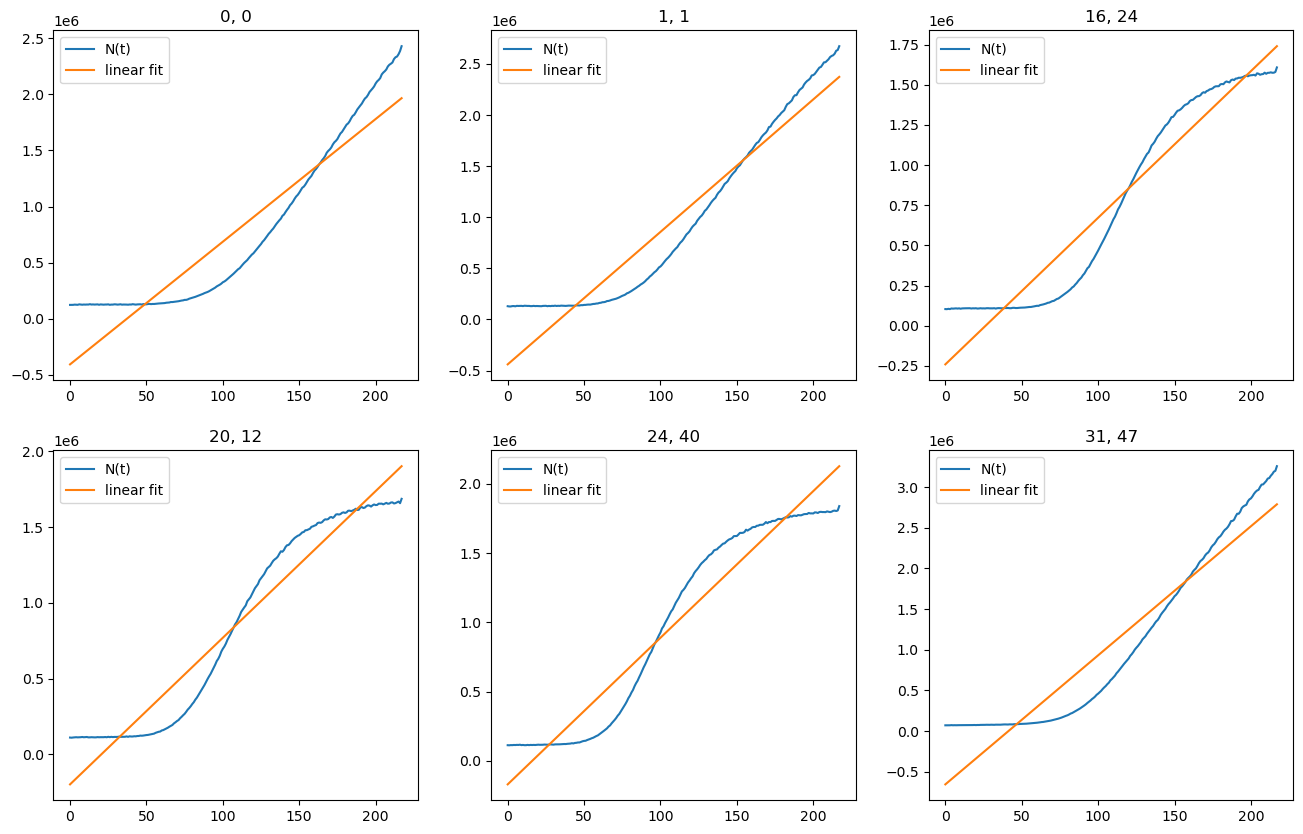

In [112]:
_, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))
i = 0
for ax in axes.flat:
    ax.plot(ts, Nt[0, coords[i][0], coords[i][1]], label = "N(t)")
    ax.plot(ts, params[i][0] * ts + params[i][1], label = "linear fit")
    a = f'{coords[i][0]}, {coords[i][1]}'
    ax.set_title(a)
    ax.legend()
    i += 1

#### Comment here on why the fits work well or not

**Answer :** Weell, it has the average right but it doesnt describe the behaviour of the growth.

## 2b. Upgrade : logistic model

A common model encountered in growth problems is the **logistic curve** :
$$
    N(t) = \frac{L}{1 + e^{-k(t-t_0)}}
$$
This model has 3 parametres ($L$, $k$ and $t_0$) which are to be fitted.

In [113]:
def lm(t, l, k, t0):
    return l / (1 + np.exp(-k * (t - t0)))

Text(0, 0.5, 'N(t)')

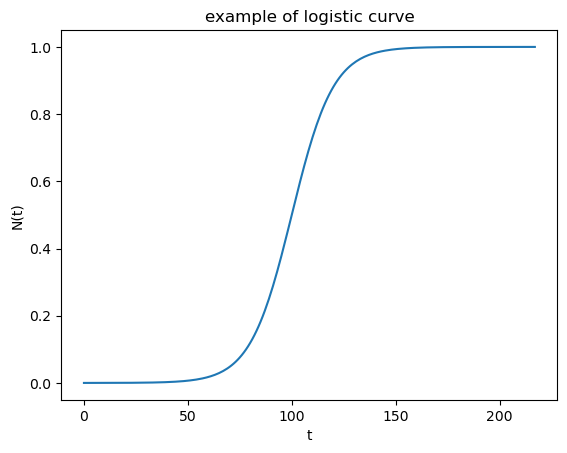

In [114]:
plt.plot(ts, lm(ts, l = 1, k = 0.1, t0 = 100))
plt.title("example of logistic curve")
plt.xlabel("t")
plt.ylabel("N(t)")

### The catastrophic failure

Adapt the code you wrote above in order to fit this time the `lm` function given above instead of a linear model :

In [115]:
params = np.empty((len(coords), 3))

In [116]:
ts = np.arange(n_points)
i = 0
for c in coords:
    (l, k, t0), _ = curve_fit(
        f     = lambda t, l, k, t0: lm(t, l, k, t0),
        xdata = ts,
        ydata = Nt[0, c[0], c[1]]
    )
    params[i] = [l, k, t0]
    i += 1

/home/elli/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


**Note :** There will be an _OptimizeWarning_ about the _covariance of the parametres_ not being _estimated_. Don't panic, this is expected.

Plot the fitted curves for every coordinate :

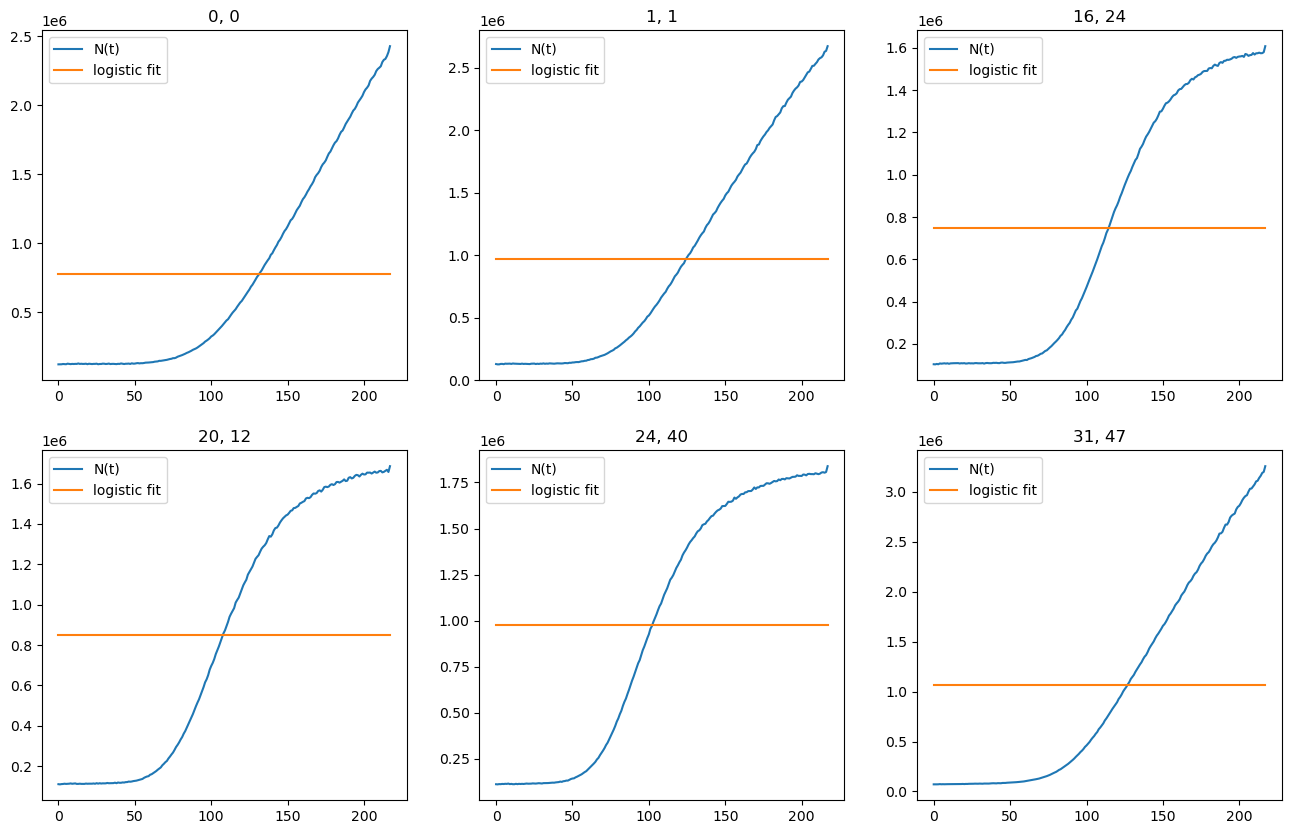

In [117]:
_, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))
i = 0
for ax in axes.flat:
    ax.plot(ts, Nt[0, coords[i][0], coords[i][1]], label = "N(t)")
    ax.plot(ts, lm(ts,params[i][0],params[i][1],params[i][2]), label = "logistic fit")
    a = f'{coords[i][0]}, {coords[i][1]}'
    ax.set_title(a)
    ax.legend()
    i += 1

Have a look at the values stored in `params` (in particular the third column, the $t_0$) :

In [118]:
pd.DataFrame(
    data    = params,
    columns = ["L", "k", "t0"],
    index   = coords
)

L          k         t0
(0, 0)    7.791423e+05  53.353919 -84.324379
(1, 1)    9.667949e+05  45.061540 -70.297490
(16, 24)  7.496366e+05  47.241960 -74.011074
(20, 12)  8.515652e+05  43.955396 -69.002607
(24, 40)  9.781239e+05  39.076641 -61.257933
(31, 47)  1.067142e+06  23.158204 -35.140450

#### Comment here on what you observe about these failed fits

**Answer :** The t0 values should be positive but for some reason they are negative there. Also k should be below 1...

### The improvement

In order to obtain a _sigmoid_, the values of $t_0$ and $k$ have to be constrained. The solver might make better assumptions if we give hints on the values of the parametres ; one way is to set such constraints. We will choose the following constraints :
* $L \in ]0, \infty[$
* $k \in ]0, 1]$
* $t_0 \in [0, \infty[$

Copy your above code, but this time providing these constraints to `curve_fit` :

In [119]:
ts = np.arange(n_points)
i = 0
lb = [0, 0, 0]
ub = [np.inf, 1, np.inf]
for c in coords:
    (l, k, t0), _ = curve_fit(
        f     = lambda t, l, k, t0: lm(t, l, k, t0),
        xdata = ts,
        ydata = Nt[0, c[0], c[1]],
        bounds = (lb, ub)
    )
    params[i] = [l, k, t0]
    i += 1

**Hint :** There is a link to the documentation for `curve_fit` earlier in this exercise ; you may want to look at the `bounds` part.

Plot the fitted curves for every coordinate :

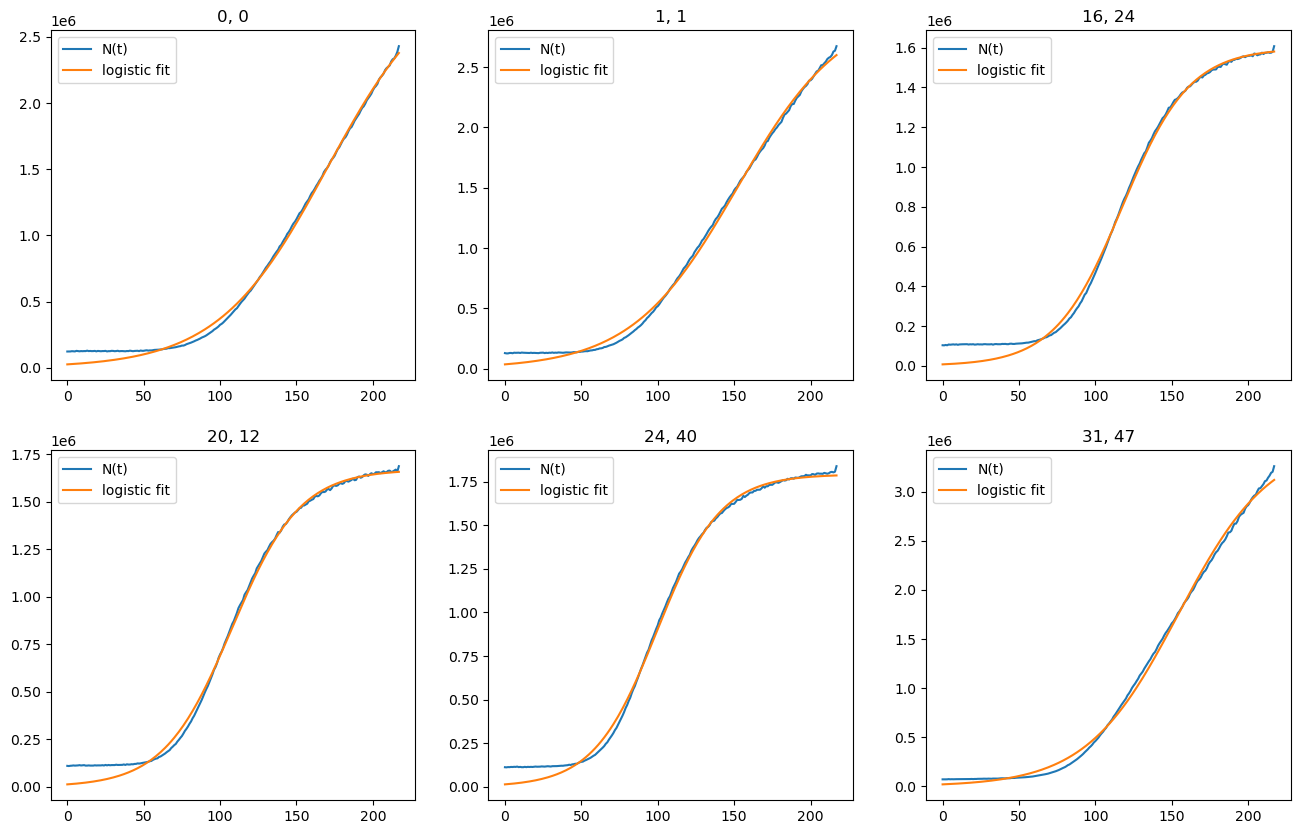

In [120]:
_, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))
i = 0
for ax in axes.flat:
    ax.plot(ts, Nt[0, coords[i][0], coords[i][1]], label = "N(t)")
    ax.plot(ts, lm(ts,params[i][0],params[i][1],params[i][2]), label = "logistic fit")
    a = f'{coords[i][0]}, {coords[i][1]}'
    ax.set_title(a)
    ax.legend()
    i += 1

#### Comment here on those upgraded fits

**Answer :** Amazingggg.

## 2c. The generalised logistic curve

The model used from now on is **Richards' curve**, which is :
$$
    N(t) = \beta + \frac{L_f}{(1 + \nu e^{-k(t-t_m)})^{1/\nu}}
$$

In [121]:
def richards(t, beta, l_f, nu, k, t_m):
    denom = 1 + nu * np.exp(-k * (t - t_m))
    return beta + l_f / np.power(denom, 1/nu)

### A 5-parametres failure

Do the fits as above, but this time using the `richards` function and setting the bounds $]0, \infty[$ for every parametre :

In [122]:
params = np.empty((len(coords), 5))

In [123]:
ts = np.arange(n_points)
i = 0
lb = [0, 0, 0, 0, 0]
ub = [np.inf, np.inf, np.inf, np.inf, np.inf]
for c in coords:
    (beta, l_f, nu, k, t_m), _ = curve_fit(
        f     = lambda t, beta, l_f, nu, k, t_m: richards(t, beta, l_f, nu, k, t_m),
        xdata = ts,
        ydata = Nt[0, c[0], c[1]],
        bounds = (lb, ub)
    )
    params[i] = [beta, l_f, nu, k, t_m]
    i += 1

/tmp/ipykernel_4128/2184696609.py:2: RuntimeWarning: overflow encountered in exp
  denom = 1 + nu * np.exp(-k * (t - t_m))
/tmp/ipykernel_4128/2184696609.py:2: RuntimeWarning: overflow encountered in multiply
  denom = 1 + nu * np.exp(-k * (t - t_m))


**Note :** This time you will get two _RuntimeWarning_ ; as before, don't be alarmed : this is expected.

Plot the curves here :

/tmp/ipykernel_4128/2184696609.py:2: RuntimeWarning: overflow encountered in exp
  denom = 1 + nu * np.exp(-k * (t - t_m))
/tmp/ipykernel_4128/2184696609.py:2: RuntimeWarning: overflow encountered in multiply
  denom = 1 + nu * np.exp(-k * (t - t_m))


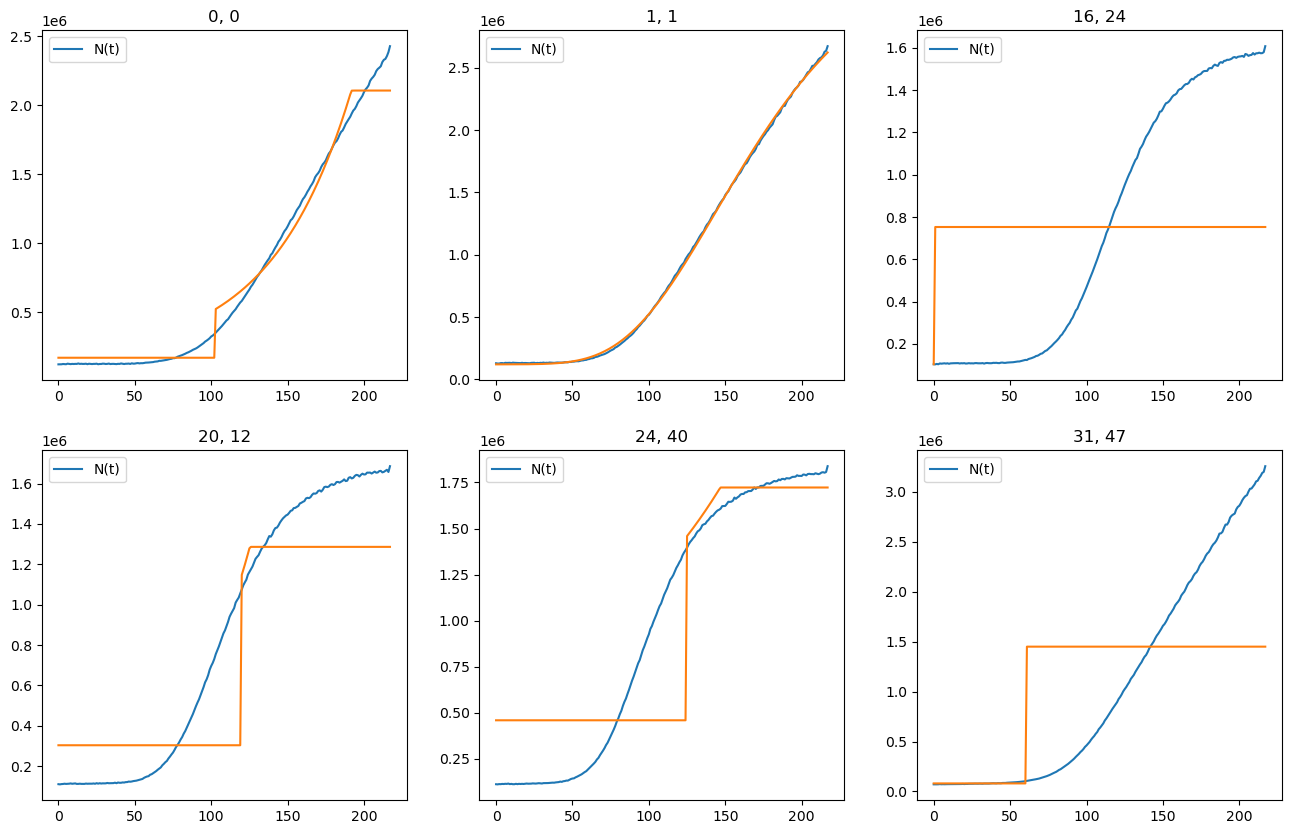

In [124]:
_, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))
i = 0
for ax in axes.flat:
    ax.plot(ts, Nt[0, coords[i][0], coords[i][1]], label = "N(t)")
    ax.plot(ts, richards(ts, params[i][0], params[i][1], params[i][2], params[i][3], params[i][4]))
    a = f'{coords[i][0]}, {coords[i][1]}'
    ax.set_title(a)
    ax.legend()
    i += 1

Let's see how those values look like :

In [125]:
pd.DataFrame(
    data    = params,
    columns = ["beta", "Lf", "nu", "k", "tm"],
    index   = coords
)

beta            Lf            nu           k          tm
(0, 0)    170566.994088  1.937253e+06  4.125347e+02    7.908183  190.991839
(1, 1)    120319.810511  3.348258e+06  2.026016e-08    0.016959  144.213277
(16, 24)   37860.542379  7.147523e+05  6.388330e+00  156.982699    0.085176
(20, 12)  303304.336584  9.830420e+05  4.659766e+03  134.983620  125.191513
(24, 40)  459674.264258  1.262801e+06  3.032211e+03   32.599183  146.526878
(31, 47)   80719.019065  1.369685e+06  4.836934e+00  931.228001   60.670466

#### Comment here on what you suppose happened this time

**Answer :** Hmmm maybe theres too many many parameters (definitely did not peek this from below).

### A 3-parametres variant

The parade for such a failure is to reduce the number of parametres to fit, but it requires us to have prior knowledge on their value. Fortunately, there are two parametres in the above model that we already know :
* $\beta$ : the number of cells at the start of the experiment
* $L_f$ : the difference between the numbers of cells at the start and end of the experiment

In this part, we will fit only the other three parametres. Find a way to make `curve_fit` vary only the last three parametres while keeping $\beta$ and $L_f$ to the above values (hint : try to understand the concept of _nested function_ and how the `lambda` keyword works) :

In [126]:
params = np.empty((len(coords), 5))

Set the first two columns of `params` to the right values for $\beta$ and $L_f$ (which you compute for each coordinate) :

In [127]:
for i, (r, c) in enumerate(coords):
    n0, nf = Nt[0, r, c].iloc[[0, -1]]
    
    params[i, 0] = n0 # beta
    params[i, 1] = nf - n0 # Lf

Now adapt the code you wrote previously, so that it calls the `richards` function inside a _lambda_ function instead of directly, allowing you to fix the $\beta$ and $L_f$ parametres you computed by hand when calling the `richards` function :

In [128]:
ts = np.arange(n_points)
i = 0
lb = [0, 0, 0]
ub = [np.inf, np.inf, np.inf]
for i, c in enumerate(coords):
    n0, nf = Nt[0, c[0], c[1]].iloc[[0, -1]]
    n2 = nf - n0
    (nu, k, t_m), _ = curve_fit(
        f     = lambda t, nu, k, t_m: richards(t, n0, n2, nu, k, t_m),
        xdata = ts,
        ydata = Nt[0, c[0], c[1]],
        bounds = (lb, ub)
    )
    params[i] = [n0, n2, nu, k, t_m]
    i += 1

**Hint 1 :** Your lambda function should take only the remaining parametres.

**Hint 2 :** You will have to find a way to store the values returned by `curve_fit` (less then 5) into the right locations in your `params` variable.

Plot the fitted curves here :

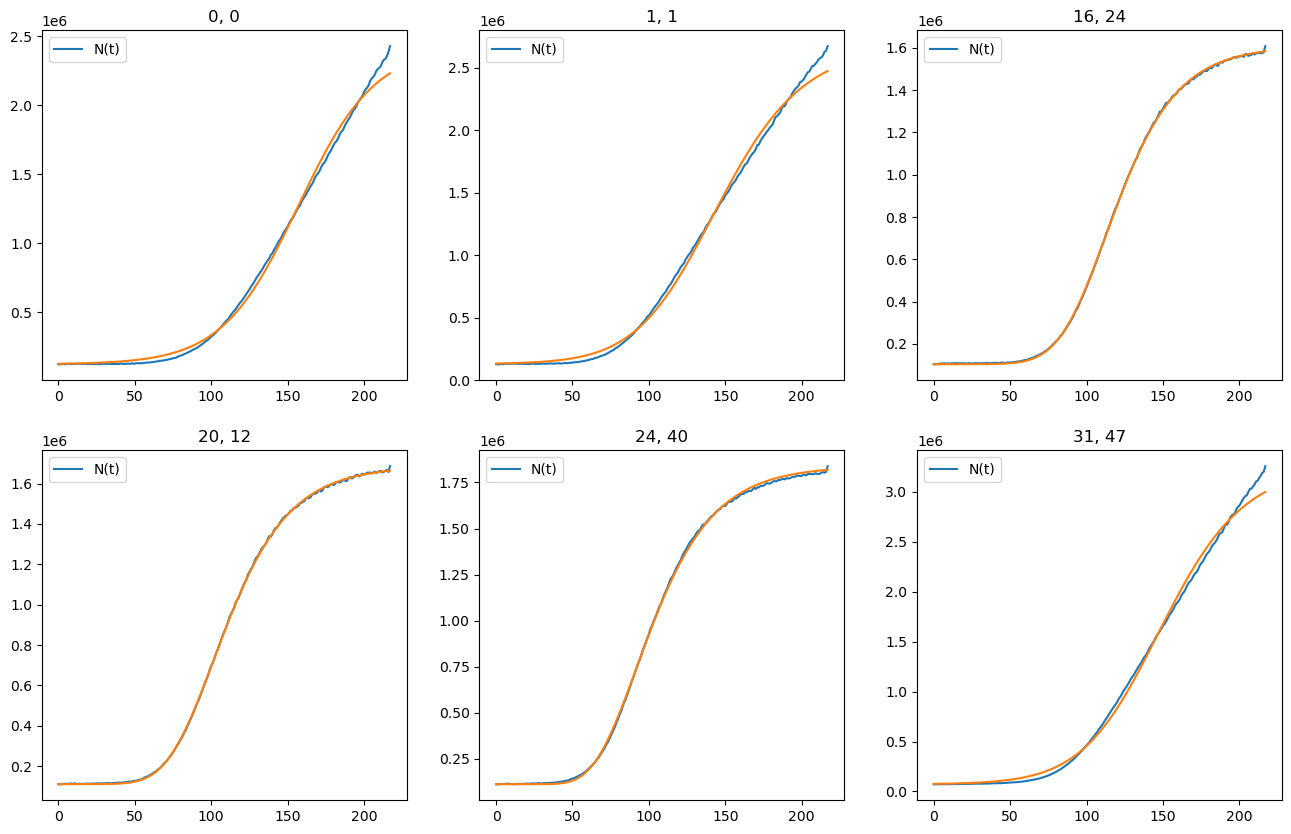

In [129]:
_, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))
i = 0
for ax in axes.flat:
    ax.plot(ts, Nt[0, coords[i][0], coords[i][1]], label = "N(t)")
    ax.plot(ts, richards(ts, params[i][0], params[i][1], params[i][2], params[i][3], params[i][4]))
    a = f'{coords[i][0]}, {coords[i][1]}'
    ax.set_title(a)
    ax.legend()
    i += 1

#### Comment here on what you observe

**Answer :** Spectacular, ever better than the amazing ones. Or at least as good.

### Back to 5 parametres

Fitting problems can become much easier if we can give some good **initial parametres** ; in the previous exercise, you fitted the last three parametres. This means that you now possess such initial parametres.

Repeat what you did, but this time by providing these initial parametres :

In [130]:
params3 = params.copy()
params  = np.empty((len(coords), 5))

In [131]:
ts = np.arange(n_points)
i = 0
lb = [0, 0, 0, 0, 0]
ub = [np.inf, np.inf, np.inf, np.inf, np.inf]
for c in coords:
    (beta, l_f, nu, k, t_m), _ = curve_fit(
        f     = lambda t, beta, l_f, nu, k, t_m: richards(t, beta, l_f, nu, k, t_m),
        xdata = ts,
        ydata = Nt[0, c[0], c[1]],
        bounds = (lb, ub),
        p0 = params3[i]
    )
    params[i] = [beta, l_f, nu, k, t_m]
    i += 1

**Hint :** There is a link to the documentation for `curve_fit` earlier in this exercise ; you may want to look at the `p0` part.

Plot the fitted curves here :

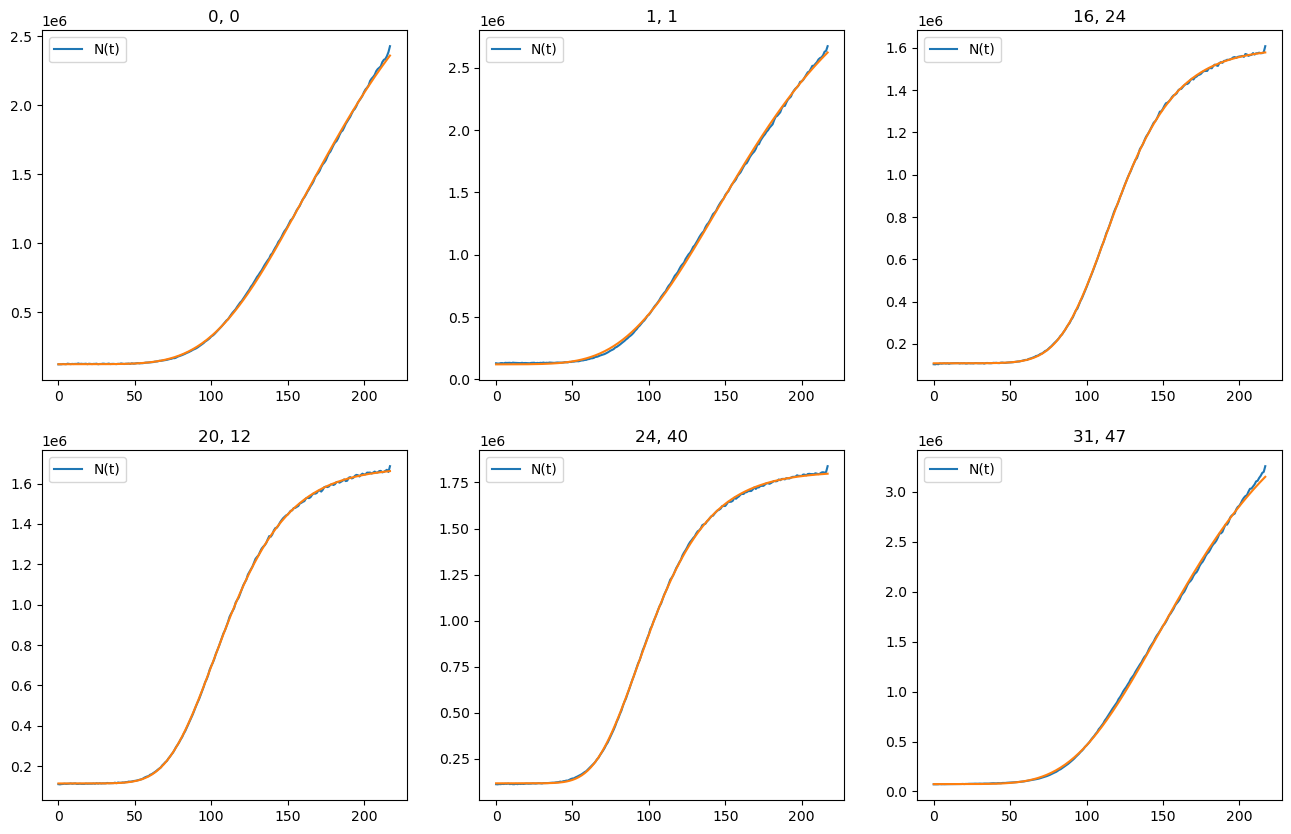

In [132]:
_, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))
i = 0
for ax in axes.flat:
    ax.plot(ts, Nt[0, coords[i][0], coords[i][1]], label = "N(t)")
    ax.plot(ts, richards(ts, params[i][0], params[i][1], params[i][2], params[i][3], params[i][4]))
    a = f'{coords[i][0]}, {coords[i][1]}'
    ax.set_title(a)
    ax.legend()
    i += 1

#### Comment here on why the last part fits better now

**Answer :** Almost indentical to the actual data, excellent! Providing the model the parameters from our previous, already wuit successful, fits, the model fitting could be started way closer to the correct curve, hence the excellent results.